In [2]:
# --------------------------- THIS IS THE BEGINNING OF THE CLEANING AND TRAINING NOTEBOOK ----------------------
#Importing Necessary Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [3]:
#reading in the .csv files we created from the landmarks [1] [2]
alpha_data = pd.DataFrame(pd.read_csv('img_alpha_dataset.csv'))
num_data = pd.DataFrame(pd.read_csv('img_nums_dataset.csv'))

In [4]:
#creating copies of the data to explore freely without affecting the original [3]
alpha_data_copy = alpha_data.copy()
num_data_copy = num_data.copy()

In [5]:
#looking at the shape of the datasets [4] [5]
print(alpha_data_copy.shape, num_data_copy.shape)

(23270, 65) (8986, 65)


In [6]:
#double checking to see if there are any null values [4] [6] [7] [8] [9]
print(alpha_data_copy.isnull().values.any(),
num_data_copy.isnull().values.any(), alpha_data_copy.isna().values.any(), num_data_copy.isna().values.any())


False False False False


# Data Exploration and Cleaning
    These steps were done for both the Alphabet and Numbers data

    - For the Data exploration I decided to explore the datasets seperately
    - First looking at the overall data distribution.
    - Second, after getting insight into the distribution I decided to look into outlier detection and removal if necessary.
    - Third, once the outliers were handled I decided to look at the handedness distribution to see if the data was weighted more toward a singular hand since this would affect the overall models predictions.
    - Lastly, removing any miscellaneous data that is a nonvalue add to our model.
 
    Once both datasets were explored and cleaned they were concatenated together to make a final dataset that will be used for training the models. The Distribution of the final dataset was also taken into account since this would affect the training.

## Exploring the Alphabet Dataset

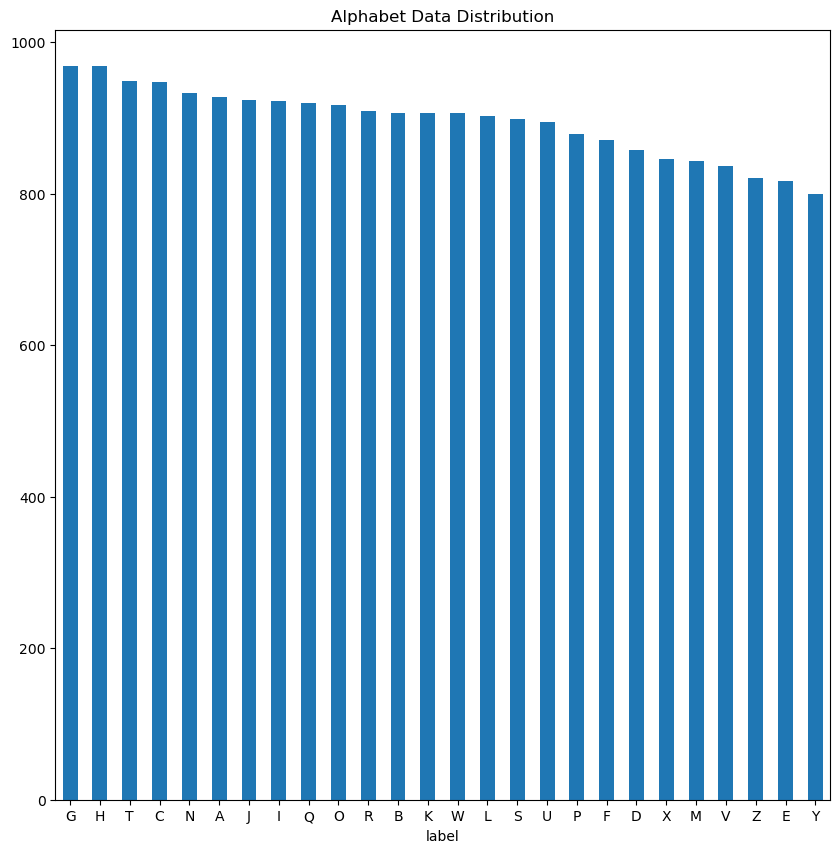

In [7]:
#seting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating a variable that houses the distinct count for each letter and plotting it in a barchart [11] [12] [13]
alpha_dist = alpha_data_copy['label'].value_counts().plot(kind='bar', ax=ax1)
#rotating the x ticks or letter because they were not straight [14] [15] [16] [17] [18] 
alpha_dist.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
plt.title('Alphabet Data Distribution')
plt.show()

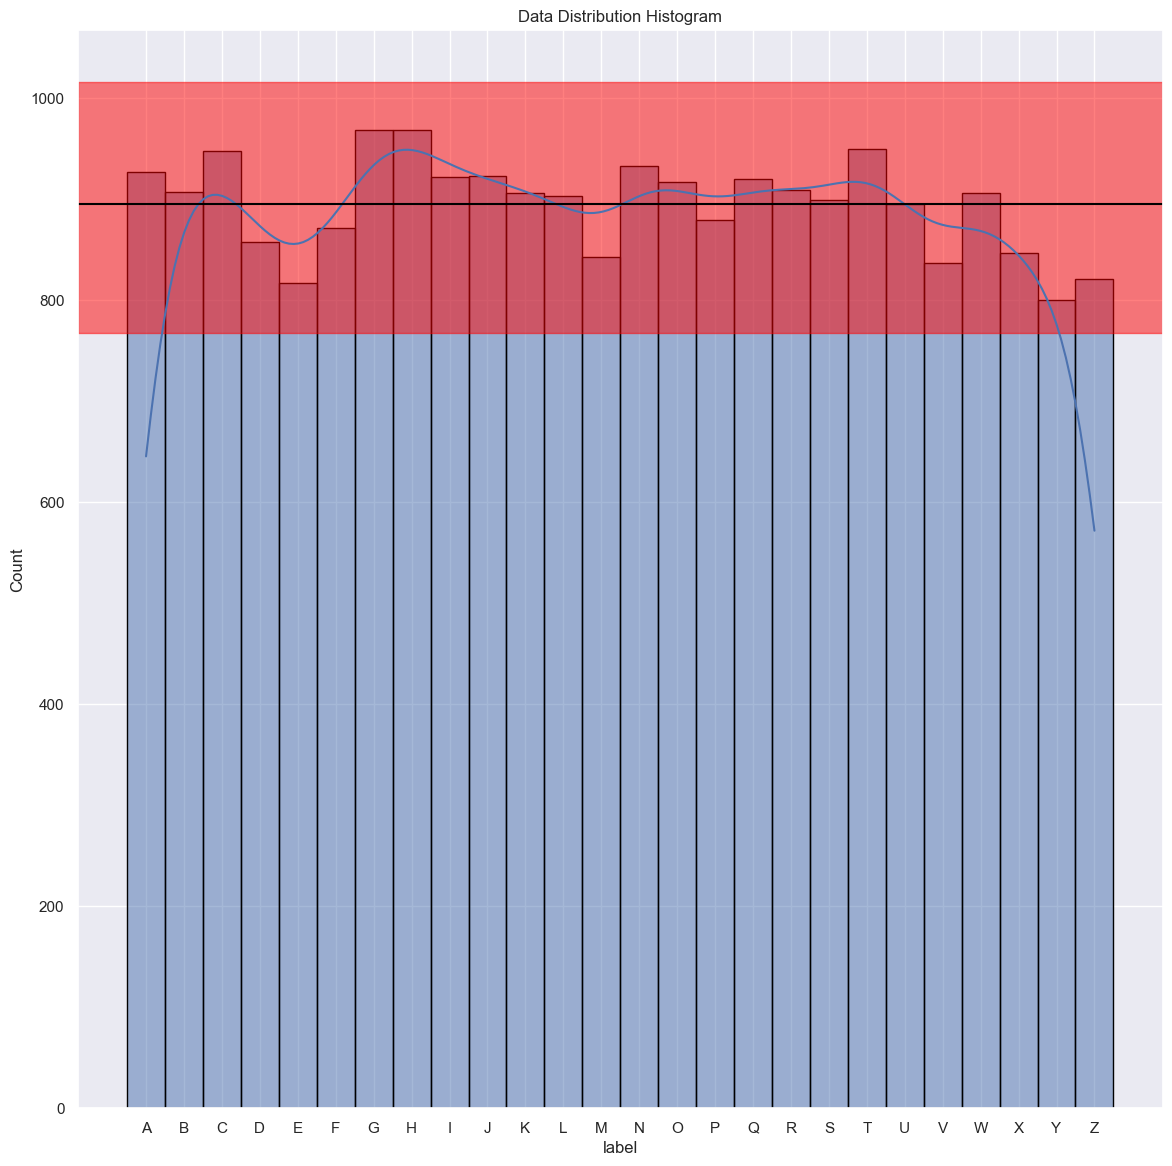

In [8]:
#creating functions to get our upper and lower bounds using the interquartile range (IQR) [19] [20] [21]
def find_lowerbound(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    lower_bound = q1 - (1.5*IQR)
    return lower_bound

def find_upperbound(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3-q1
    upper_bound = q3 + (1.5*IQR)
    return upper_bound
#creating a variable with the upper and lower bound of our label colum to use in the data dist histogram [11] [12]
alpha_lower = find_lowerbound(alpha_data_copy['label'].value_counts())
alpha_upper = find_upperbound(alpha_data_copy['label'].value_counts())

# creating the a seaborn histogram based on the above distribution 
#setting the figure size using rc and custom params via "niraj" suggestion to the stack overflow question at [25]. [22] [23] [24] [26]
sns.set(rc={'figure.figsize':(14,14)})
#creating the histogram [11] [27]
sns.histplot(alpha_data_copy['label'], kde=True, edgecolor='black')
#creating a horizontal line of the mean counts for all letter and displaying it on our histogram [28] [11] [12] [29]
plt.axhline(alpha_data_copy['label'].value_counts().mean(),
            color='black')
#this displays a rectangle over the histogram creating a bounding box
#where the top of the rectangle is the upper limit and the bottom the lower limit
#everything within the box would be within the limits and outside would be an outlier [30] [17] [18]
plt.axhspan(alpha_lower, alpha_upper, color='red', alpha = 0.5)
plt.title('Data Distribution Histogram')
plt.show()


Text(0.5, 1.0, 'Data Boxplot')

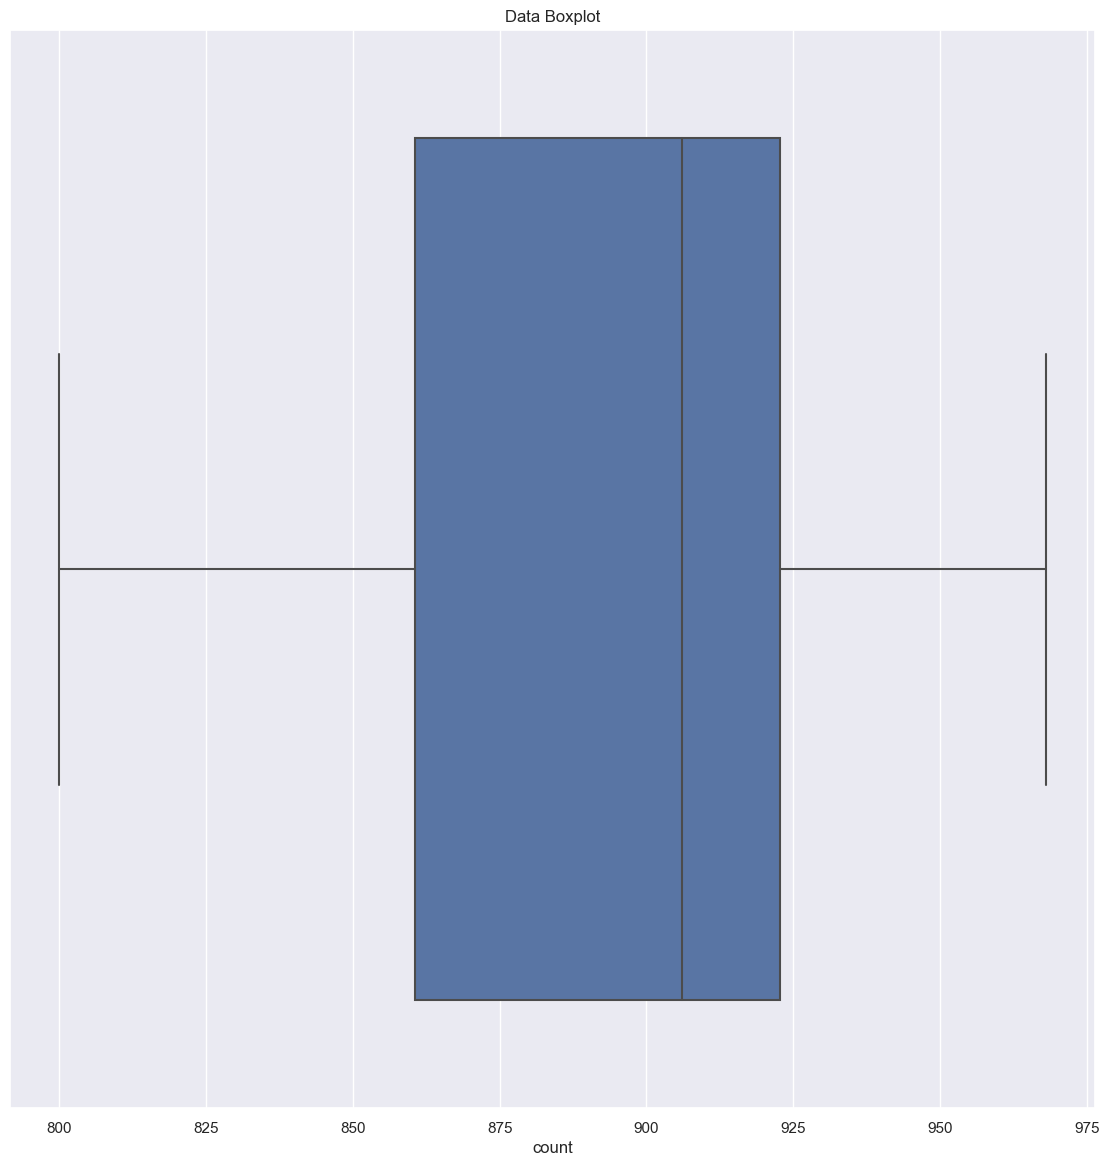

In [149]:
#setting the figure size [24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
#creating a boxplot to visualize the label data outliers via a different method than shown above [31] [11] [12] [17]
sns.boxplot(x=alpha_data_copy['label'].value_counts())
plt.title('Data Boxplot')

## Alphabet Handedness

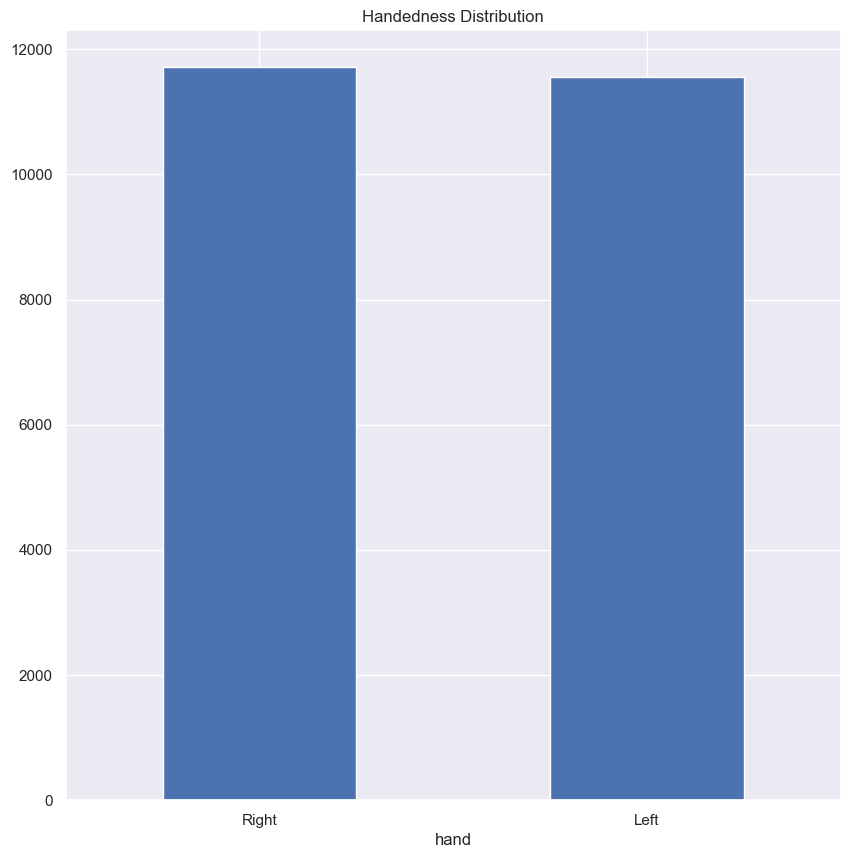

In [10]:
#setting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating a variable that houses the distinct count for each hand and plotting it in a barchart [11] [12] [13]
alpha_dist = alpha_data_copy['hand'].value_counts().plot(kind='bar', ax=ax1)
#rotating the x ticks or letter because they were not straight [14] [15] [16] [17] [18] 
alpha_dist.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0) 
plt.title('Handedness Distribution') 
plt.show()

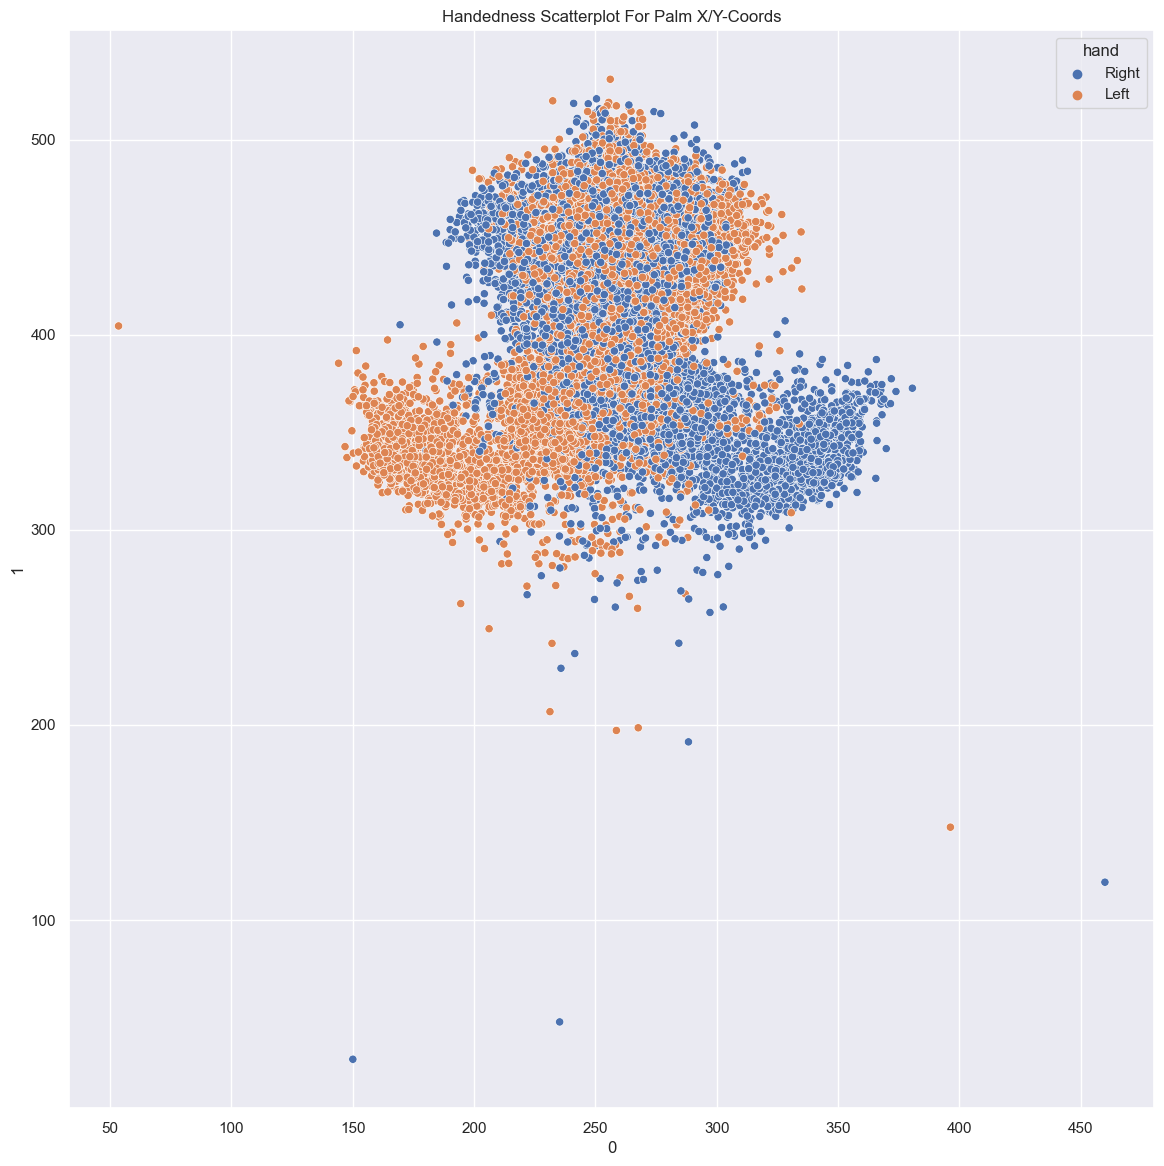

In [11]:
sns.scatterplot(data=alpha_data_copy, x=alpha_data_copy['0'], y=alpha_data_copy['1'], hue=alpha_data_copy.hand)
plt.title('Handedness Scatterplot For Palm X/Y-Coords') 
plt.show()

In [12]:
#getting the upper and lower bound for each hand  [11] [12]
right_lower = find_lowerbound(alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label.value_counts())
right_upper = find_upperbound(alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label.value_counts())
#left hand [11] [12]
left_lower = find_lowerbound(alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label.value_counts())
left_upper = find_upperbound(alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label.value_counts())
#getting the average (mean) of the two to display as our bounding box manually [32]
hand_mean_lower = (right_lower + left_lower) / 2
hand_mean_upper = (right_upper + left_upper) / 2

#Getting the mean of the counts [11] [12] [29]
right_mean = alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label.value_counts().mean()
left_mean = alpha_data_copy[(alpha_data_copy['hand'] == 'Left')].label.value_counts().mean()
#manual average [32]
hand_mean_count = (right_mean + left_mean) / 2
# printing the upper and lower bounds [4]
print(hand_mean_lower, hand_mean_upper, hand_mean_count)


345.0 557.0 447.5


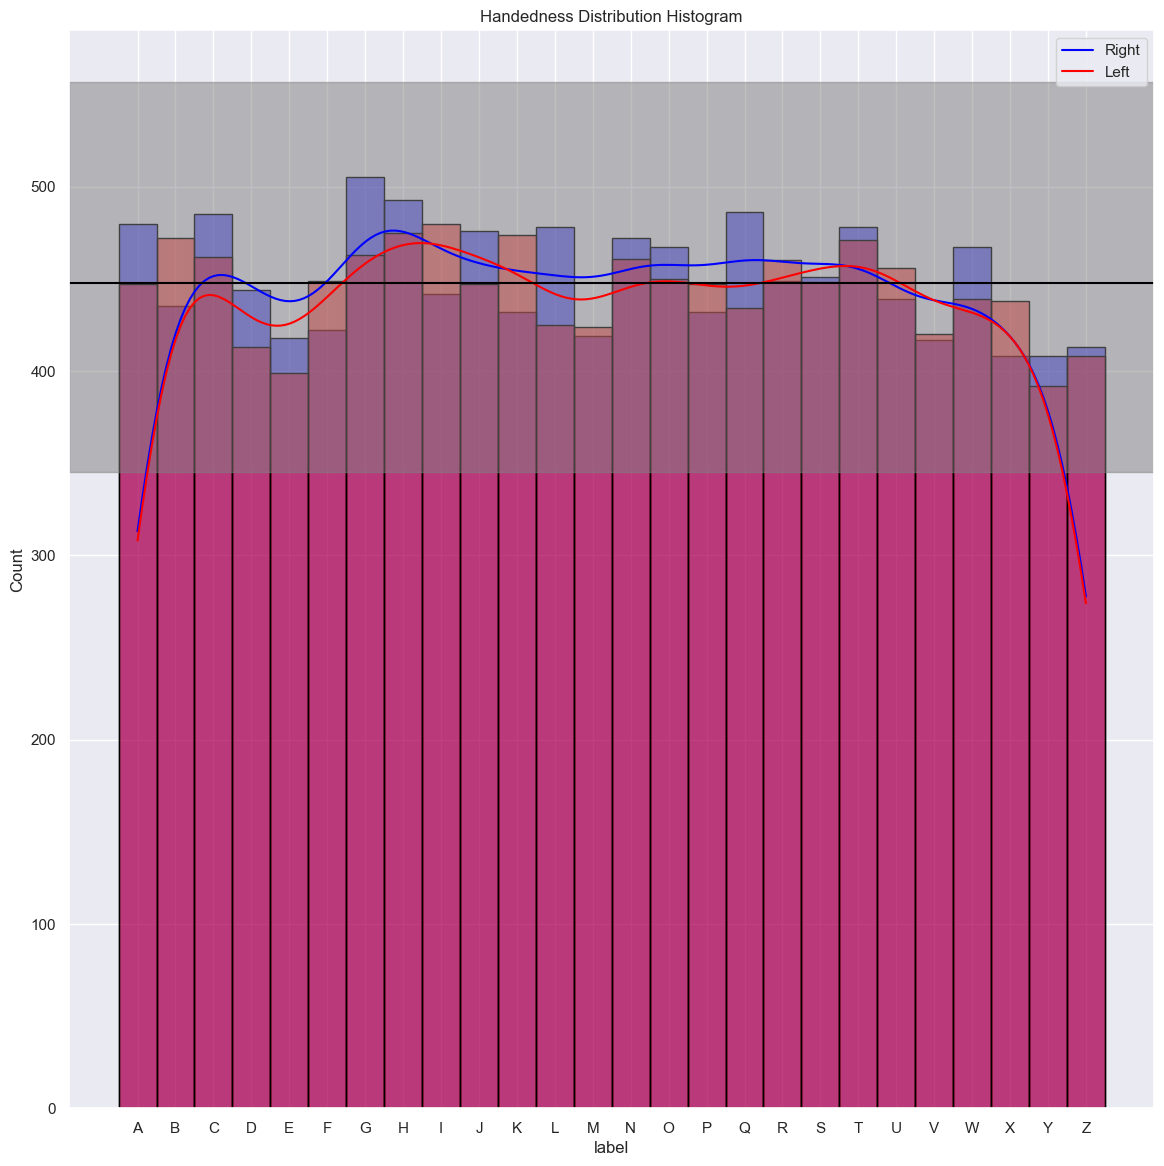

In [13]:
#Creating a histogram of the different hand types [24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
#histogram for right and left with the mean of their counts and a bounding box of their upper and lower limits [11] [27] [28] [29] [30]
sns.histplot(alpha_data_copy[(alpha_data_copy['hand'] == 'Right')].label, color='blue', kde=True, edgecolor='black')
sns.histplot(alpha_data_copy[(alpha_data_copy['hand'] == 'Left')].label, color='red', kde=True, edgecolor='black')
plt.axhline(hand_mean_count, color='black')
plt.axhspan(hand_mean_lower, hand_mean_upper, color='grey', alpha = 0.5)
#adding a legend since we are stacking histograms to display both right and left hands [33] [17] [18]
plt.legend(['Right', 'Left'])
plt.title('Handedness Distribution Histogram')
plt.show()

## Miscellaneous Data Removal

In [14]:
#The dataset still has J and Z value so i will establish an X and y and remove them
#getting the indices of the J and Z data [11] [34]
idxj = alpha_data_copy[(alpha_data_copy['label']=='J')].index
idxz = alpha_data_copy[(alpha_data_copy['label']=='Z')].index

#dropping J and Z from the dataset [35]
alpha_data_minus = alpha_data_copy.drop(index=idxj)
alpha_data_minus2 = alpha_data_minus.drop(index=idxz)

#printing the initial copied dataset, the newly created dataset missing J and Z, and printing the initial subtracted from both indices for verification [4]
print(len(alpha_data_copy), len(alpha_data_minus2), (len(alpha_data_copy) -  (len(idxj)+len(idxz))))

23270 21526 21526


In [15]:
#Seeing how much of the data set I removed [4]
print("J and Z accounted for", round((len(alpha_data_copy) - len(alpha_data_minus2))/ len(alpha_data_copy), 3), "percent of the dataset.")

J and Z accounted for 0.075 percent of the dataset.


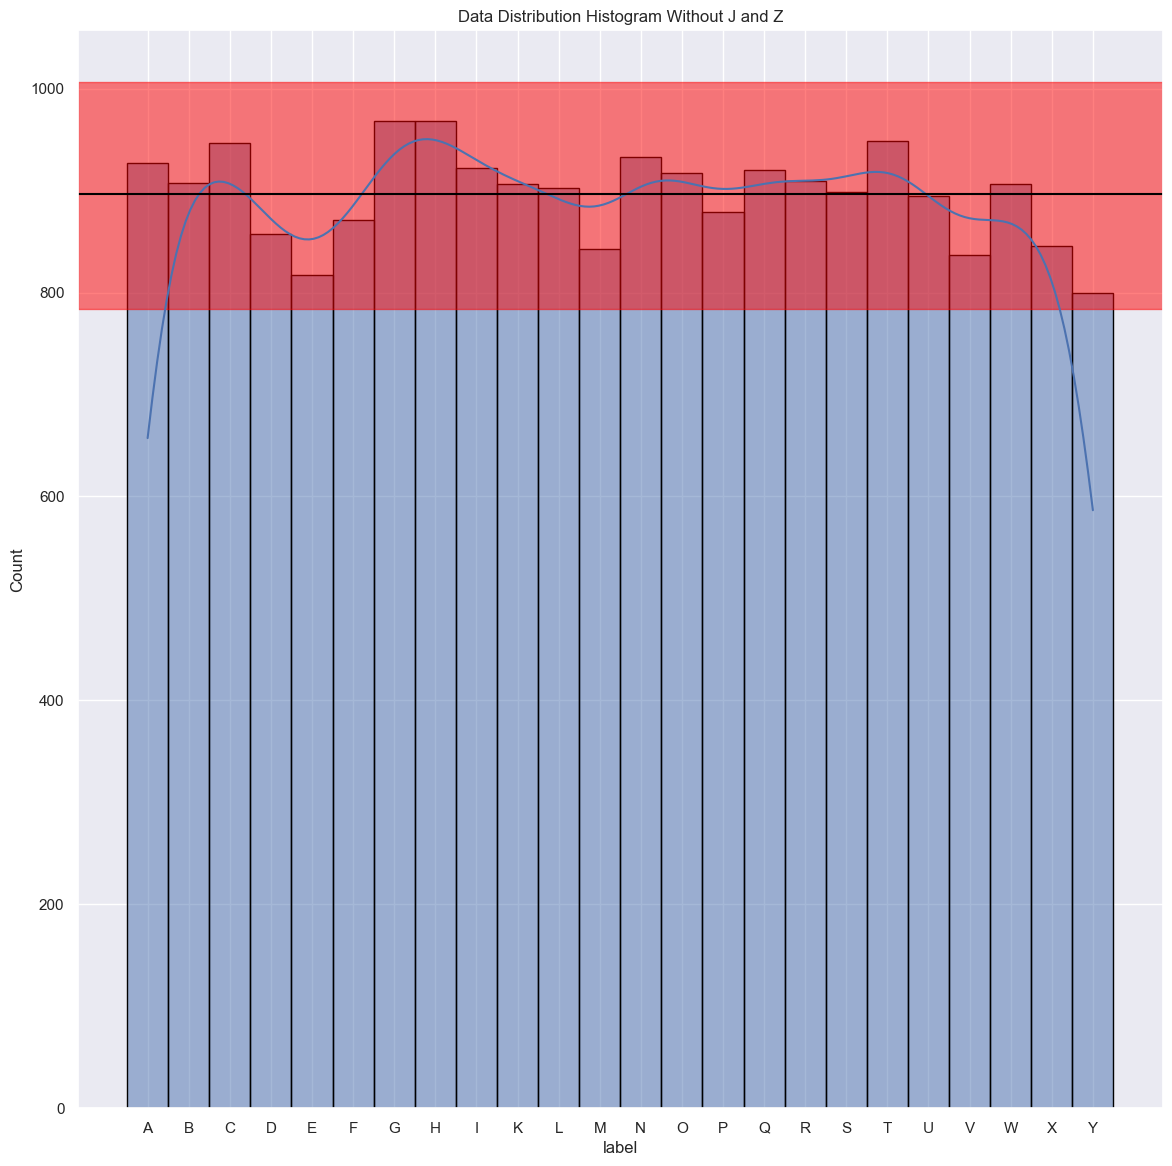

In [16]:
#verifying the removal of J and Z did not affect the dataset like creating outliers [11] [12]
alpha_lower1 = find_lowerbound(alpha_data_minus2['label'].value_counts())
alpha_upper1 = find_upperbound(alpha_data_minus2['label'].value_counts())

# creating the data dist histogram [11] [17] [18] [24] [25] [26] [27] [28] [29] [30]
sns.set(rc={'figure.figsize':(14,14)})
sns.histplot(alpha_data_minus2['label'], kde=True, edgecolor='black')
plt.axhline(alpha_data_minus2['label'].value_counts().mean(),
            color='black')
plt.axhspan(alpha_lower1, alpha_upper1, color='red', alpha = 0.5)
plt.title('Data Distribution Histogram Without J and Z')
plt.show()

## Exlporing the Number dataset

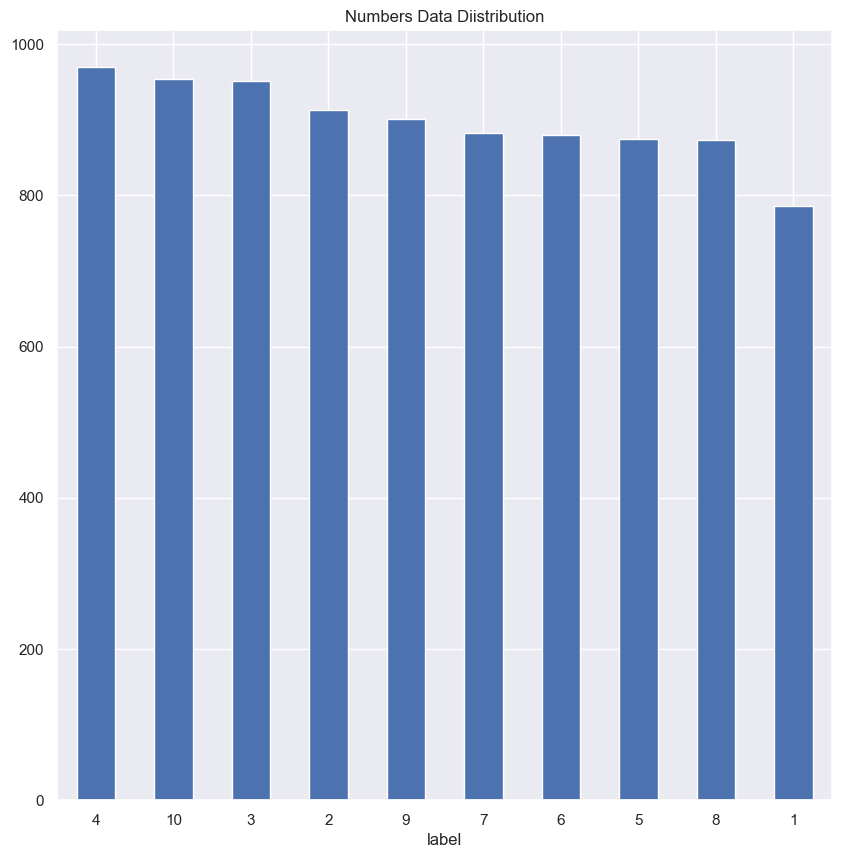

In [17]:
#seting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating a variable that houses the distinct count for each letter and plotting it in a barchart [11] [12] [13]
num_dist = num_data_copy['label'].value_counts().plot(kind='bar', ax=ax1)
#rotating the x ticks or letter because they were not straight [14] [15] [16] [17] [18] 
num_dist.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
plt.title('Numbers Data Diistribution')
plt.show()

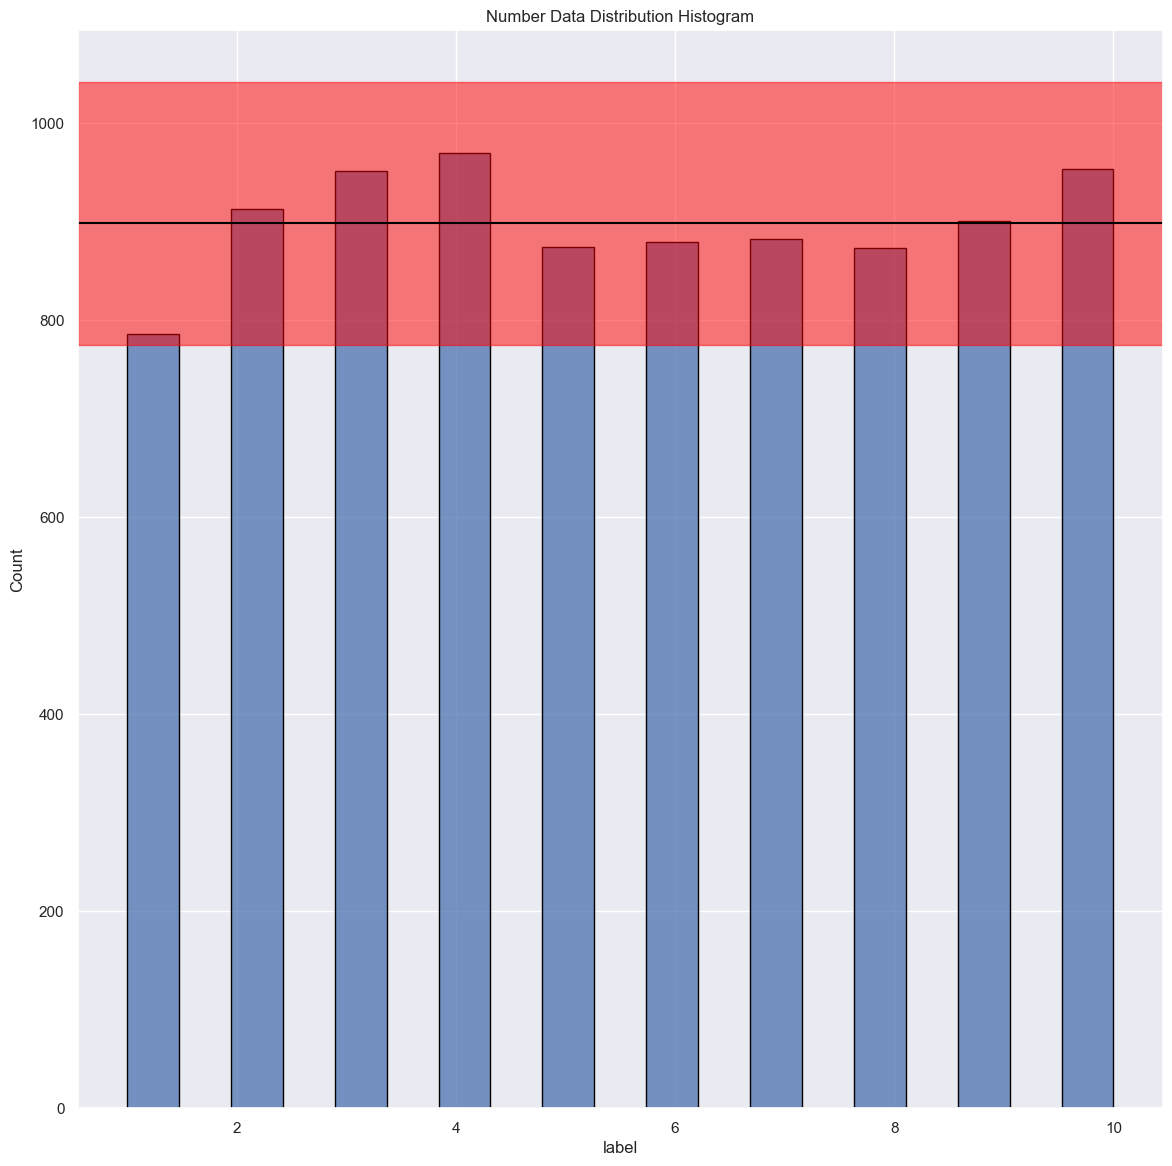

In [18]:
#creating a variable with the upper and lower bound of our label colum to use in the data dist histogram [11][12]
num_lower = find_lowerbound(num_data_copy['label'].value_counts())
num_upper = find_upperbound(num_data_copy['label'].value_counts())

# creating the a seaborn histogram based on the above distribution
#setting the figure size [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
#creating the histogram, with mean line, and bounding box for numbers data [11] [17] [18] [24] [25] [26] [27] [28] [29] [30]
sns.histplot(num_data_copy['label'], edgecolor='black')
plt.axhline(num_data_copy['label'].value_counts().mean(),
            color='black')
plt.axhspan(num_lower, num_upper, color='red', alpha = 0.5)
plt.title('Number Data Distribution Histogram')
plt.show()

## Number Handedness

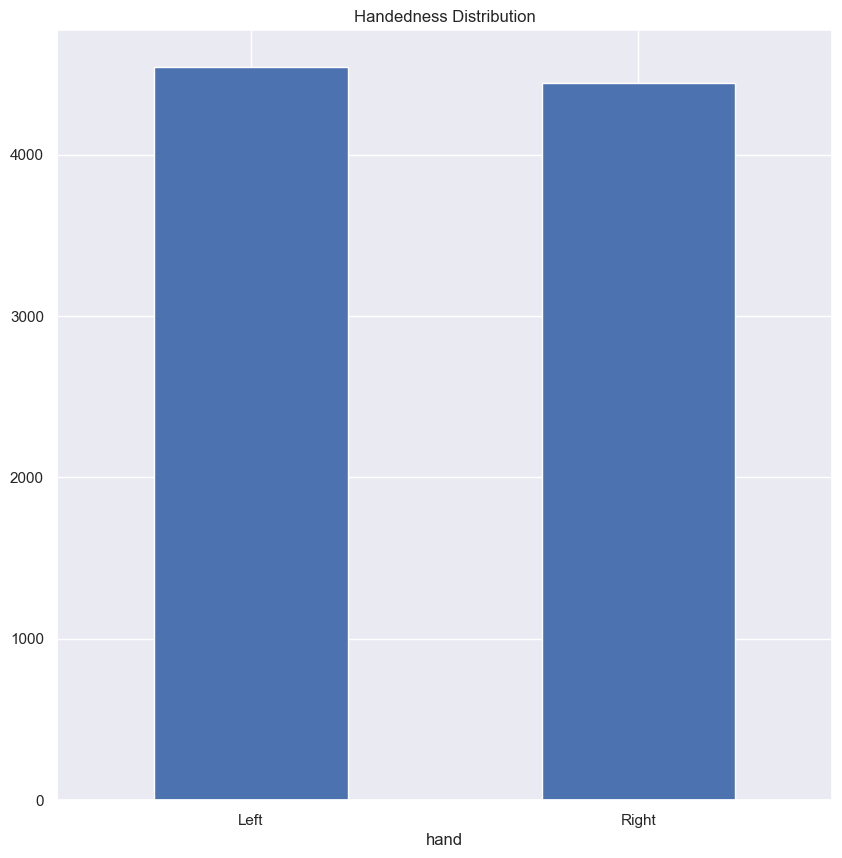

In [19]:
#seting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating a variable that houses the distinct count for each hand and plotting it in a barchart [11] [12] [13]
num_dist = num_data_copy['hand'].value_counts().plot(kind='bar', ax=ax1)
#rotating the x ticks or letter because they were not straight [14] [15] [16] [17] [18]
num_dist.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
plt.title('Handedness Distribution')
plt.show()

In [20]:
#getting the upper and lower bound for each hand [11] [12]
right_lower = find_lowerbound(num_data_copy[(num_data_copy['hand'] == 'Right')].label.value_counts())
right_upper = find_upperbound(num_data_copy[(num_data_copy['hand'] == 'Right')].label.value_counts())
#left hand [11] [12]
left_lower = find_lowerbound(num_data_copy[(num_data_copy['hand'] == 'Right')].label.value_counts())
left_upper = find_upperbound(num_data_copy[(num_data_copy['hand'] == 'Right')].label.value_counts())
#getting the average of the two to display as our bounding box [32]
hand_mean_lower = (right_lower + left_lower) / 2
hand_mean_upper = (right_upper + left_upper) / 2

#Getting the mean of the counts [11] [12] [29]
right_mean = num_data_copy[(num_data_copy['hand'] == 'Right')].label.value_counts().mean()
left_mean = num_data_copy[(num_data_copy['hand'] == 'Left')].label.value_counts().mean()
#manual average [32]
hand_mean_count = (right_mean + left_mean) / 2
# [4]
print(hand_mean_lower, hand_mean_upper, hand_mean_count)

357.0 517.0 449.29999999999995


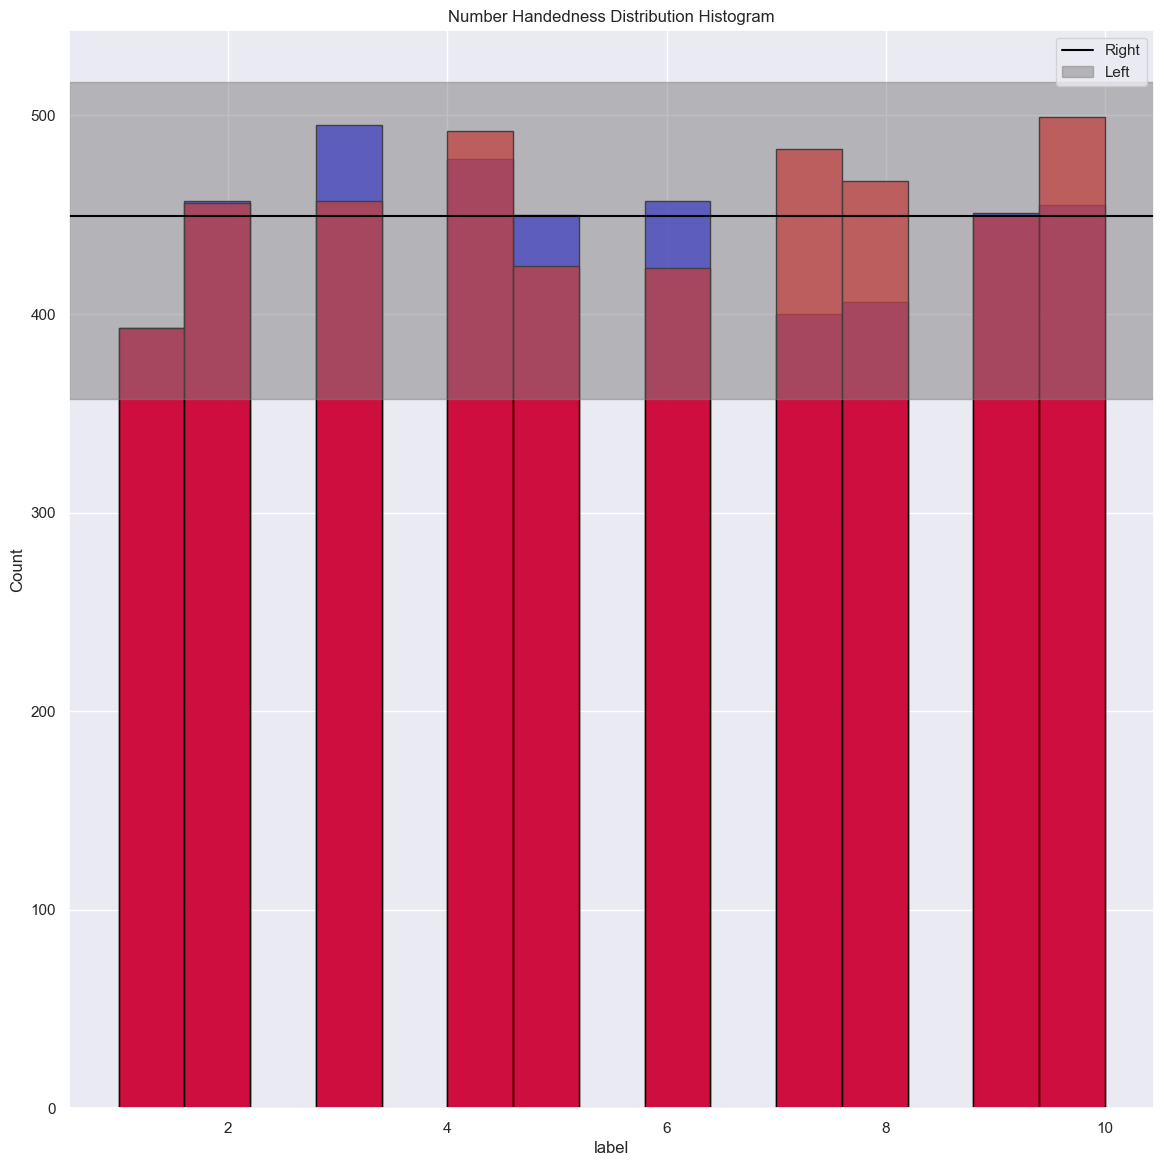

In [21]:
#Creating a histogram of the different hand types [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
#histogram for right and left with the mean of their counts and a bounding box of their upper and lower limits [11] [17] [18] [24] [25] [26] [27] [28] [29] [30] [33]
sns.histplot(num_data_copy[(num_data_copy['hand'] == 'Right')].label, color='blue', edgecolor='black')
sns.histplot(num_data_copy[(num_data_copy['hand'] == 'Left')].label, color='red', edgecolor='black')
plt.axhline(hand_mean_count, color='black')
plt.axhspan(hand_mean_lower, hand_mean_upper, color='grey', alpha = 0.5)
plt.legend(['Right', 'Left'])
plt.title('Number Handedness Distribution Histogram')
plt.show()

## Fixing miscellaneous data issues with our Number data.

In [22]:
#Since our data is categorical and the data came label with their numeric value I want the word representation since I plan to use label encoding for the features [36]
num_data_copy.label.replace({1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10:'ten'}, inplace=True)
#creating a copy of the num_data_copy dataframe with the new word representation data for our number labels [3]
num_data_rename = num_data_copy.copy()

In [23]:
#concatenating the two alphabet and number dataframes to create our main dataframe [37]
data_copy = pd.concat([alpha_data_minus2, num_data_rename])

## New Combined dataset

In [24]:
#verifying the new dataframe has the correct labels [38]
np.unique(data_copy.label)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'eight',
       'five', 'four', 'nine', 'one', 'seven', 'six', 'ten', 'three',
       'two'], dtype=object)

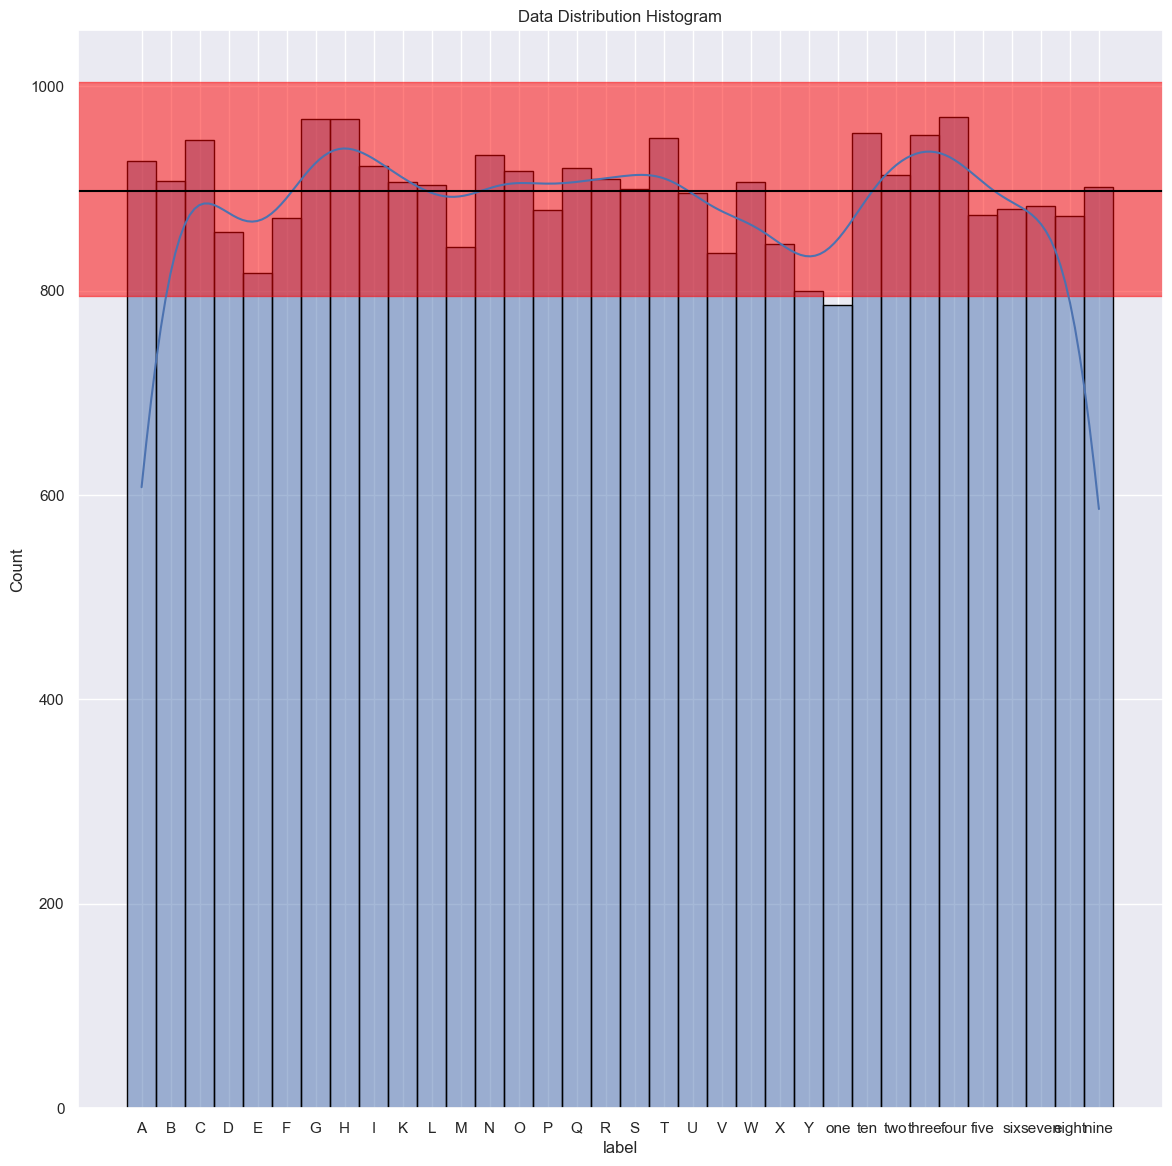

In [25]:
#Looking at the new data dist and verifying if there are outliers
#creating a variable with the upper and lower bound of our label colum to use in the data dist histogram [11] [12]
data_lower = find_lowerbound(data_copy['label'].value_counts())
data_upper = find_upperbound(data_copy['label'].value_counts())

# creating the a seaborn histogram based on the above distribution
#setting the figure size[22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
#creating the histogram [11] [17] [18] [24] [25] [26] [27] [28] [29] [30] [33]
sns.histplot(data_copy['label'], kde=True, edgecolor='black')
plt.axhline(data_copy['label'].value_counts().mean(),
            color='black')
plt.axhspan(data_lower, data_upper, color='red', alpha = 0.5)
plt.title('Data Distribution Histogram')
plt.show()
#One is an outlier but i do not think it will affect the training since we are going to split the data making it more evenly distributed [4]


## Preparing the Data for Training

In [26]:
#setting our X and y data or feature and response variables [3] [35]
X = data_copy.drop(columns=['label', 'hand'])
y = data_copy['label'].copy()

In [27]:
#looking at the new shape [4] [5]
print(y.shape, X.shape)


(30512,) (30512, 63)


In [28]:
#Label encoding the response variables [39]
label_encoded = preprocessing.LabelEncoder()
fitted_LE = label_encoded.fit(y)
y_LE = fitted_LE.transform(y)

In [29]:
#Splitting the data using train_test_split [40]
X_train, X_test, y_train, y_test = train_test_split(X.values, y_LE, test_size=0.2, random_state=42)

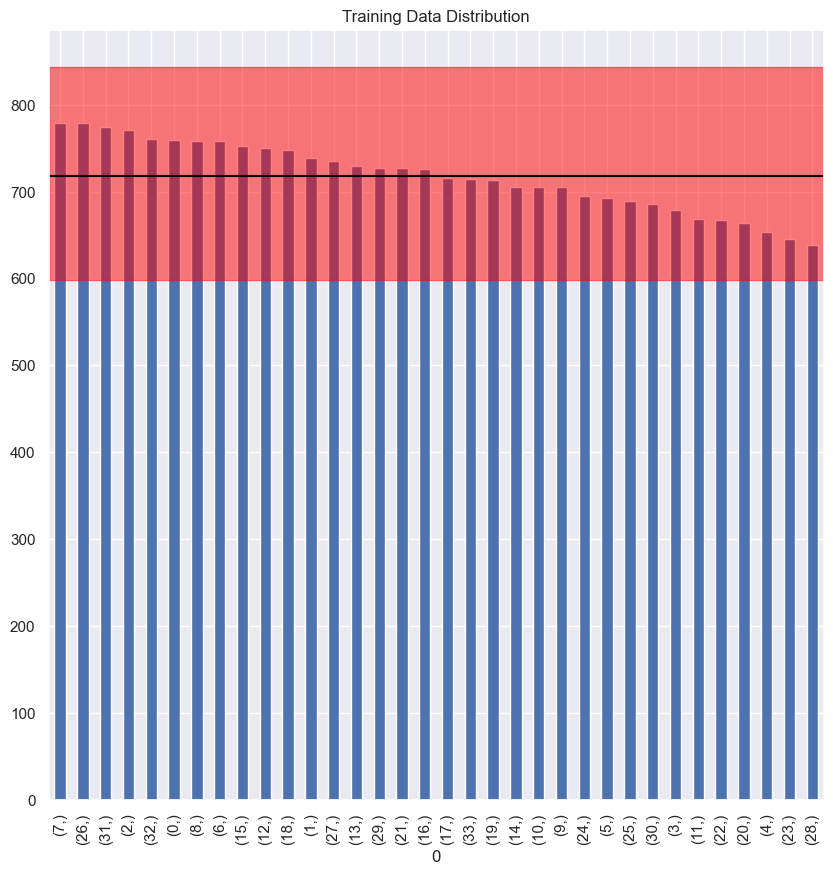

In [30]:
#creating a variable of the response variables for our visualization
train_count = pd.DataFrame(y_train).value_counts()
#Looking at the new data dist and verifying if there are outliers
#creating a variable with the upper and lower bound of our label colum to use in the data dist histogram [11] [12]
train_lower = find_lowerbound(train_count)
train_upper = find_upperbound(train_count)
#seting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating the histogram [11] [12] [13]
train_dist = train_count.plot(kind='bar', ax=ax1)
plt.axhline(train_count.mean(),
            color='black')
plt.axhspan(train_lower, train_upper, color='red', alpha = 0.5)
plt.title('Training Data Distribution')
plt.show()

# Building the Sequential Model
- Exploring a sequential model through the use of "rule-of-thumb" methods for number of neurons. [64]

In [40]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 2 layers [41] [42] [43] [44] [45]
seq_model = keras.models.Sequential([
    keras.layers.Dense(49, input_dim=63, activation="relu"),
    keras.layers.Dense(49, input_dim=63, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted = seq_model.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 4.6058 - accuracy: 0.0405
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5283 - accuracy: 0.0307
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5280 - accuracy: 0.0304
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5281 - accuracy: 0.0303
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5734 - accuracy: 0.0284
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5280 - accuracy: 0.0303
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5277 - accuracy: 0.0300
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5282 - accuracy: 0.0301
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5281 - accuracy: 0.0302
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5281 - accura

In [41]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 4 layers [41] [42] [43] [44] [45]
seq_model2 = keras.models.Sequential([
    keras.layers.Dense(49, input_dim=63, activation="relu"),
    keras.layers.Dense(49, activation="relu"),
    keras.layers.Dense(49, activation="relu"),
    keras.layers.Dense(49, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted2 = seq_model2.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 1.9047 - accuracy: 0.5092
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6835 - accuracy: 0.7707
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6077 - accuracy: 0.7999
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5235 - accuracy: 0.8297
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 0.4710 - accuracy: 0.8531
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.8265
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6126 - accuracy: 0.8035
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5535 - accuracy: 0.8160
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 0.7615 - accuracy: 0.7552
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 0.8447 - accura

In [42]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 1 layers [41] [42] [43] [44] [45]
seq_model3 = keras.models.Sequential([
    keras.layers.Dense(62, input_dim=63, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.03)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted3 = seq_model3.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 8.0707 - accuracy: 0.0304
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5327 - accuracy: 0.0313
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5326 - accuracy: 0.0299
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5333 - accuracy: 0.0308
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5336 - accuracy: 0.0293
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5330 - accuracy: 0.0295
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5323 - accuracy: 0.0300
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5335 - accuracy: 0.0293
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5330 - accuracy: 0.0294
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5331 - accura

In [43]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 3 layers [41] [42] [43] [44] [45]
seq_model4 = keras.models.Sequential([
    keras.layers.Dense(62, input_dim=63, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model4.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted4 = seq_model4.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 2.5548 - accuracy: 0.5444
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6570 - accuracy: 0.7806
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.8237
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5594 - accuracy: 0.8212
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5124 - accuracy: 0.8424
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.8292
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6117 - accuracy: 0.8180
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5500 - accuracy: 0.8323
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5824 - accuracy: 0.8244
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 0.4961 - accura

In [44]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 5 layers [41] [42] [43] [44] [45]
seq_model5 = keras.models.Sequential([
    keras.layers.Dense(62, input_dim=63, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.03)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model5.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted5 = seq_model5.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 2ms/step - loss: 4.7556 - accuracy: 0.0377
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5327 - accuracy: 0.0318
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5326 - accuracy: 0.0304
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5333 - accuracy: 0.0305
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5336 - accuracy: 0.0295
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5330 - accuracy: 0.0295
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5323 - accuracy: 0.0300
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5335 - accuracy: 0.0293
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5330 - accuracy: 0.0294
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5331 - accura

In [45]:
#Exploring neurons between the size of the input and the size of the output [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 4 layers [41] [42] [43] [44] [45]
seq_model6 = keras.models.Sequential([
    keras.layers.Dense(62, input_dim=63, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(62, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model6.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted6 = seq_model6.fit(np.array(X_train), np.array(y_train), epochs=150)

Epoch 1/150
763/763 [==============================] - 1s 1ms/step - loss: 3.3473 - accuracy: 0.1964
Epoch 2/150
763/763 [==============================] - 1s 1ms/step - loss: 1.3359 - accuracy: 0.5004
Epoch 3/150
763/763 [==============================] - 1s 1ms/step - loss: 0.9868 - accuracy: 0.6366
Epoch 4/150
763/763 [==============================] - 1s 1ms/step - loss: 0.9259 - accuracy: 0.6618
Epoch 5/150
763/763 [==============================] - 1s 1ms/step - loss: 0.8185 - accuracy: 0.7151
Epoch 6/150
763/763 [==============================] - 1s 1ms/step - loss: 0.8387 - accuracy: 0.7000
Epoch 7/150
763/763 [==============================] - 1s 1ms/step - loss: 0.8203 - accuracy: 0.7105
Epoch 8/150
763/763 [==============================] - 1s 1ms/step - loss: 0.7908 - accuracy: 0.7234
Epoch 9/150
763/763 [==============================] - 1s 1ms/step - loss: 0.7817 - accuracy: 0.7283
Epoch 10/150
763/763 [==============================] - 1s 1ms/step - loss: 0.8234 - accura

In [46]:
#Exploring the number of neurons equal to 2/3 of the input layer plus the size of the output layer [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 3 layers [41] [42] [43] [44] [45]
seq_model7 = keras.models.Sequential([
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model7.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted7 = seq_model7.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 3.9408 - accuracy: 0.2612
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 1.0663 - accuracy: 0.6208
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 0.7683 - accuracy: 0.7285
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6995 - accuracy: 0.7600
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6470 - accuracy: 0.7823
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5432 - accuracy: 0.8167
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5489 - accuracy: 0.8190
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5949 - accuracy: 0.8162
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5058 - accuracy: 0.8360
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 0.4673 - accura

In [47]:
#Exploring the number of neurons equal to 2/3 of the input layer plus the size of the output layer [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 4 layers [41] [42] [43] [44] [45]
seq_model8 = keras.models.Sequential([
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(77, input_dim=63, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model8.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted8 = seq_model8.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 1ms/step - loss: 2.5926 - accuracy: 0.4731
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 0.8143 - accuracy: 0.7201
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6042 - accuracy: 0.7957
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 0.5735 - accuracy: 0.8105
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6192 - accuracy: 0.8057
Epoch 6/100
763/763 [==============================] - 1s 2ms/step - loss: 0.5115 - accuracy: 0.8429
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 0.4887 - accuracy: 0.8475
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 0.8289 - accuracy: 0.7405
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6195 - accuracy: 0.7967
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 0.6127 - accura

In [37]:
y_pred4 = np.argmax(seq_model9.predict(X_test), axis=1)
acc4 = accuracy_score(y_test, y_pred4)
prec4 = precision_score(y_test, y_pred4, average='weighted', zero_division=0)
rec4 = recall_score(y_test, y_pred4, average='weighted')
print(acc4, prec4, rec4)

191/191 [==============================] - 0s 1ms/step
0.7142388989021793 0.7199423014487126 0.7142388989021793


In [48]:
#Exploring the nureons that are less than twice the size of the input layer [64]
#Setting a random seed for our keras model [51]
keras.utils.set_random_seed(42)
#creating a sequential model with 4 layers [41] [42] [43] [44] [45]
seq_model9 = keras.models.Sequential([
    keras.layers.Dense(125, input_dim=63, activation="relu"),
    keras.layers.Dense(125, input_dim=63, activation="relu"),
    keras.layers.Dense(125, input_dim=63, activation="relu"),
    keras.layers.Dense(35, activation="softmax")
])
#creating the optimizer with the my desired learning rate [46] [47]
optimizer = keras.optimizers.Adam(learning_rate=0.01)
#compiling the model with our desired loss, optimizer, and metric [48] [49] [50]
seq_model9.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#fitting the model [50]
seq_fitted9 = seq_model9.fit(np.array(X_train), np.array(y_train), epochs=100)

Epoch 1/100
763/763 [==============================] - 1s 2ms/step - loss: 5.6724 - accuracy: 0.0324
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5282 - accuracy: 0.0313
Epoch 3/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5280 - accuracy: 0.0312
Epoch 4/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5283 - accuracy: 0.0302
Epoch 5/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5285 - accuracy: 0.0287
Epoch 6/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5282 - accuracy: 0.0296
Epoch 7/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5278 - accuracy: 0.0302
Epoch 8/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5282 - accuracy: 0.0299
Epoch 9/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5281 - accuracy: 0.0302
Epoch 10/100
763/763 [==============================] - 1s 1ms/step - loss: 3.5281 - accura

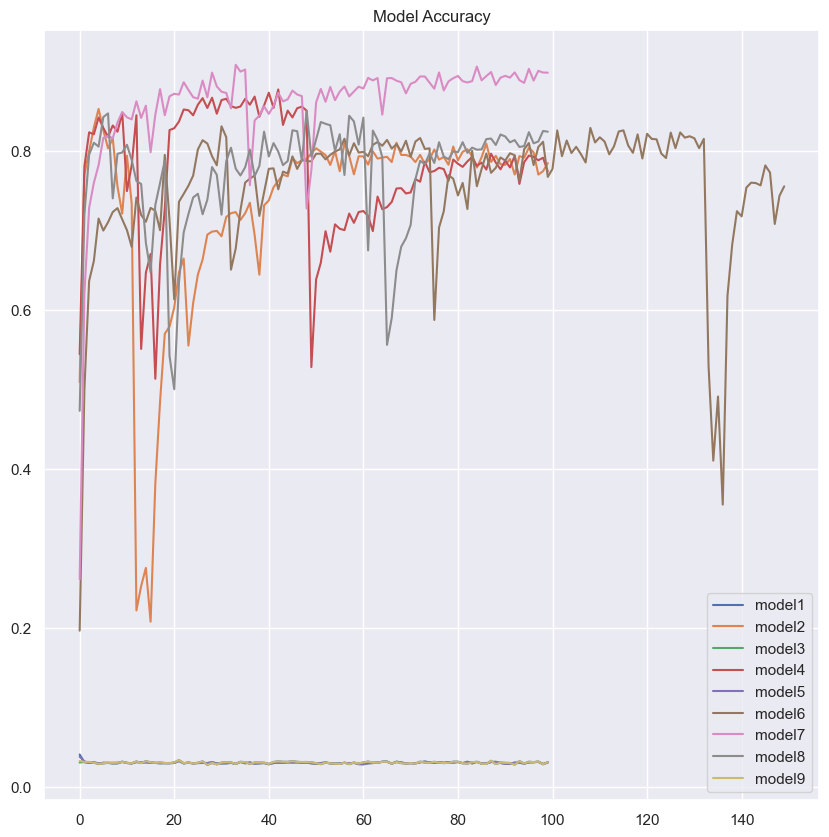

In [61]:
#seting our figure and axis [10]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
#creating the Line Chart [11] [12] [13]
model1 = plt.plot(seq_fitted.history['accuracy']),
model2 = plt.plot(seq_fitted2.history['accuracy']),
model3 = plt.plot(seq_fitted3.history['accuracy']),
model4 = plt.plot(seq_fitted4.history['accuracy']),
model5 = plt.plot(seq_fitted5.history['accuracy']),
model6 = plt.plot(seq_fitted6.history['accuracy']),
model7 = plt.plot(seq_fitted7.history['accuracy']),
model8 = plt.plot(seq_fitted8.history['accuracy']),
model9 = plt.plot(seq_fitted9.history['accuracy'])
plt.legend(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9'])
plt.title('Model Accuracy')
plt.show()

In [ ]:
#creating our y prediction variable to house the largest prediciton percentage for each prediction [53]
y_pred1 = np.argmax(seq_model.predict(X_test), axis=1)
y_pred2 = np.argmax(seq_model2.predict(X_test), axis=1)
y_pred3 = np.argmax(seq_model3.predict(X_test), axis=1)
y_pred4 = np.argmax(seq_model4.predict(X_test), axis=1)
y_pred5 = np.argmax(seq_model5.predict(X_test), axis=1)
y_pred6 = np.argmax(seq_model6.predict(X_test), axis=1)
y_pred7 = np.argmax(seq_model7.predict(X_test), axis=1)
y_pred8 = np.argmax(seq_model8.predict(X_test), axis=1)
y_pred9 = np.argmax(seq_model9.predict(X_test), axis=1)

In [72]:
#Getting the accuracy score of all of the models to use in our graph to see which ones are the best [60]
acc1 = accuracy_score(y_test, y_pred1)
acc2 = accuracy_score(y_test, y_pred2)
acc3 = accuracy_score(y_test, y_pred3)
acc4 = accuracy_score(y_test, y_pred4)
acc5 = accuracy_score(y_test, y_pred5)
acc6 = accuracy_score(y_test, y_pred6)
acc7 = accuracy_score(y_test, y_pred7)
acc8 = accuracy_score(y_test, y_pred8)
acc9 = accuracy_score(y_test, y_pred9)

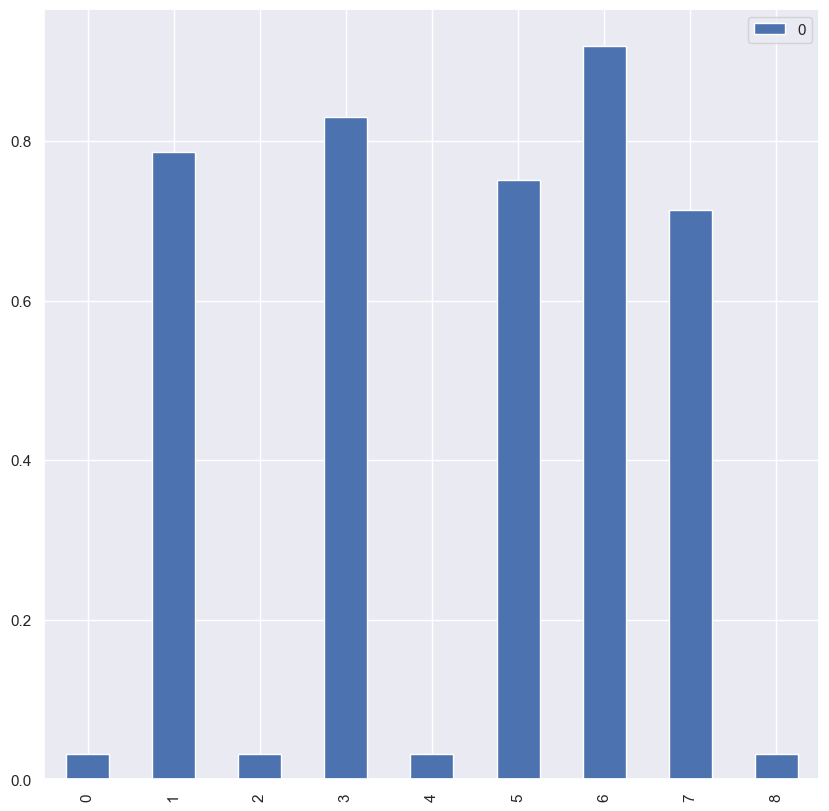

In [69]:
#seting our figure and axis [10] 
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()
# Creating a dataframe and plotting our accuracy scores in a bar chart to easily discern which two are the top models [1] [52] [13] [17]
pd.DataFrame([acc1,acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9]).plot(kind='bar', ax=ax1) 
plt.show()

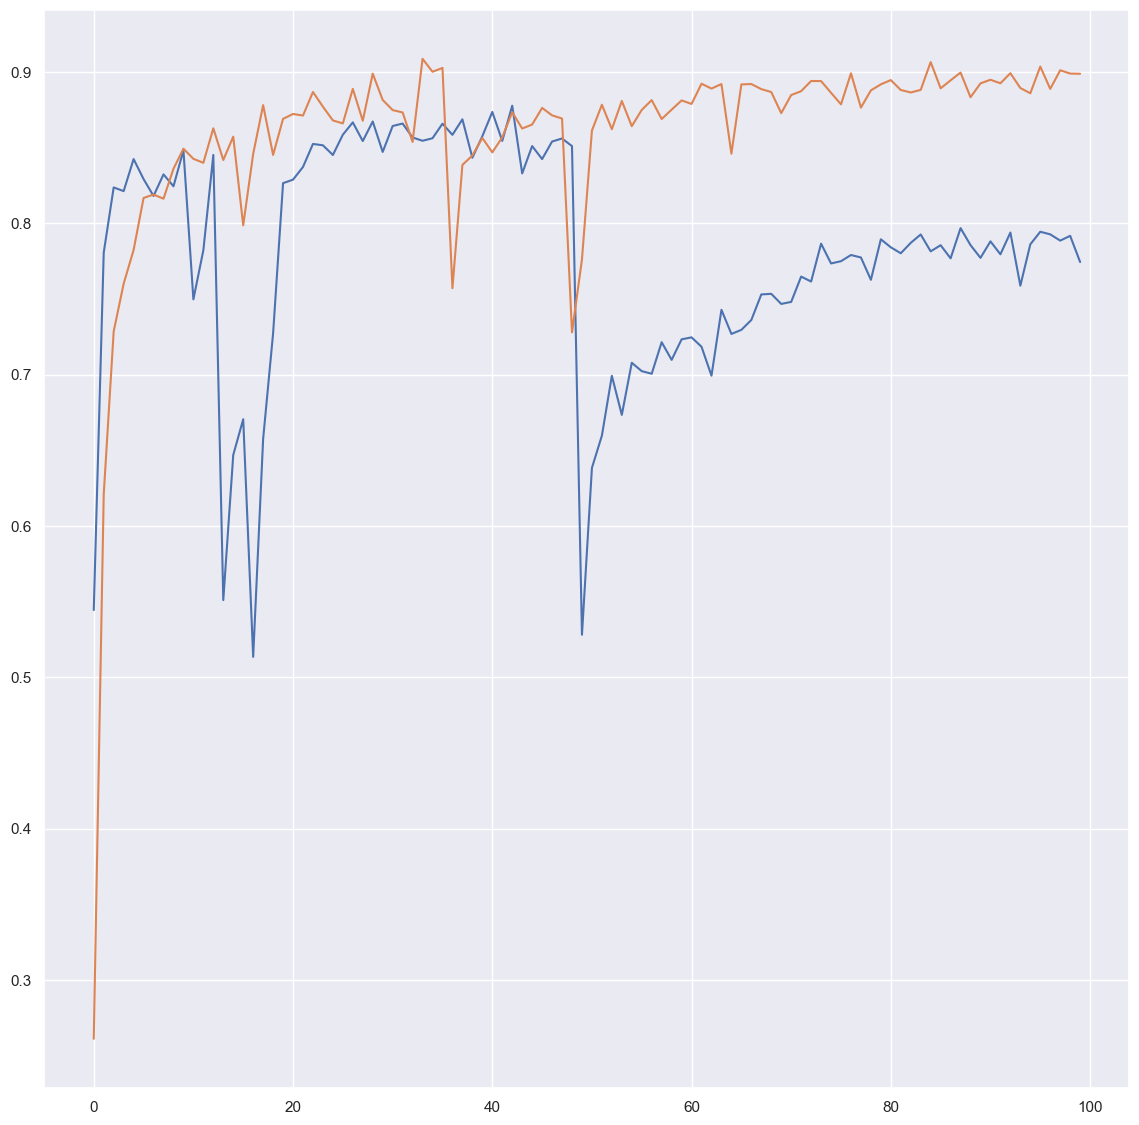

In [71]:
# Plotting the accuracy for our best models [1] [52] [13] [17]
plt.plot(seq_fitted4.history['accuracy']) 
plt.plot(seq_fitted7.history['accuracy']) 
plt.show()

In [76]:
#getting our precision and recall score for our best sequential model predictions [54] [55] [4]
prec4 = precision_score(y_test, y_pred4, average='weighted', zero_division=0)
rec4 = recall_score(y_test, y_pred4, average='weighted')
print('Model4: ', 'Accuracy:',acc4, 'Precision:',prec4, 'Recall:',rec4)

prec7 = precision_score(y_test, y_pred7, average='weighted', zero_division=0)
rec7 = recall_score(y_test, y_pred7, average='weighted')
print('Model7: ', 'Accuracy:',acc7, 'Precision:',prec7, 'Recall:',rec7)

Model4:  Accuracy: 0.8302474193019826 Precision: 0.8517361882294512 Recall: 0.8302474193019826
Model7:  Accuracy: 0.9192200557103064 Precision: 0.9277420407885795 Recall: 0.9192200557103064


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
#printing the classification report for our best sequential model to see how each response variable did [56] [4] [65]
print('Classification Report: Model4\n', classification_report(y_test, y_pred4), 'Classification Report: Model7\n', classification_report(y_test, y_pred7))


Classification Report: Model4
               precision    recall  f1-score   support

           0       0.80      0.96      0.88       168
           1       0.90      0.83      0.86       168
           2       0.97      0.94      0.96       176
           3       0.64      0.97      0.77       178
           4       0.93      0.84      0.88       163
           5       0.99      0.96      0.97       178
           6       0.91      0.82      0.86       210
           7       0.93      0.81      0.86       189
           8       1.00      0.99      1.00       164
           9       0.93      0.92      0.92       201
          10       0.96      0.99      0.97       198
          11       0.92      0.76      0.83       175
          12       0.67      0.97      0.79       183
          13       0.83      0.96      0.89       187
          14       0.97      0.97      0.97       174
          15       0.86      0.72      0.79       168
          16       0.77      0.39      0.52       

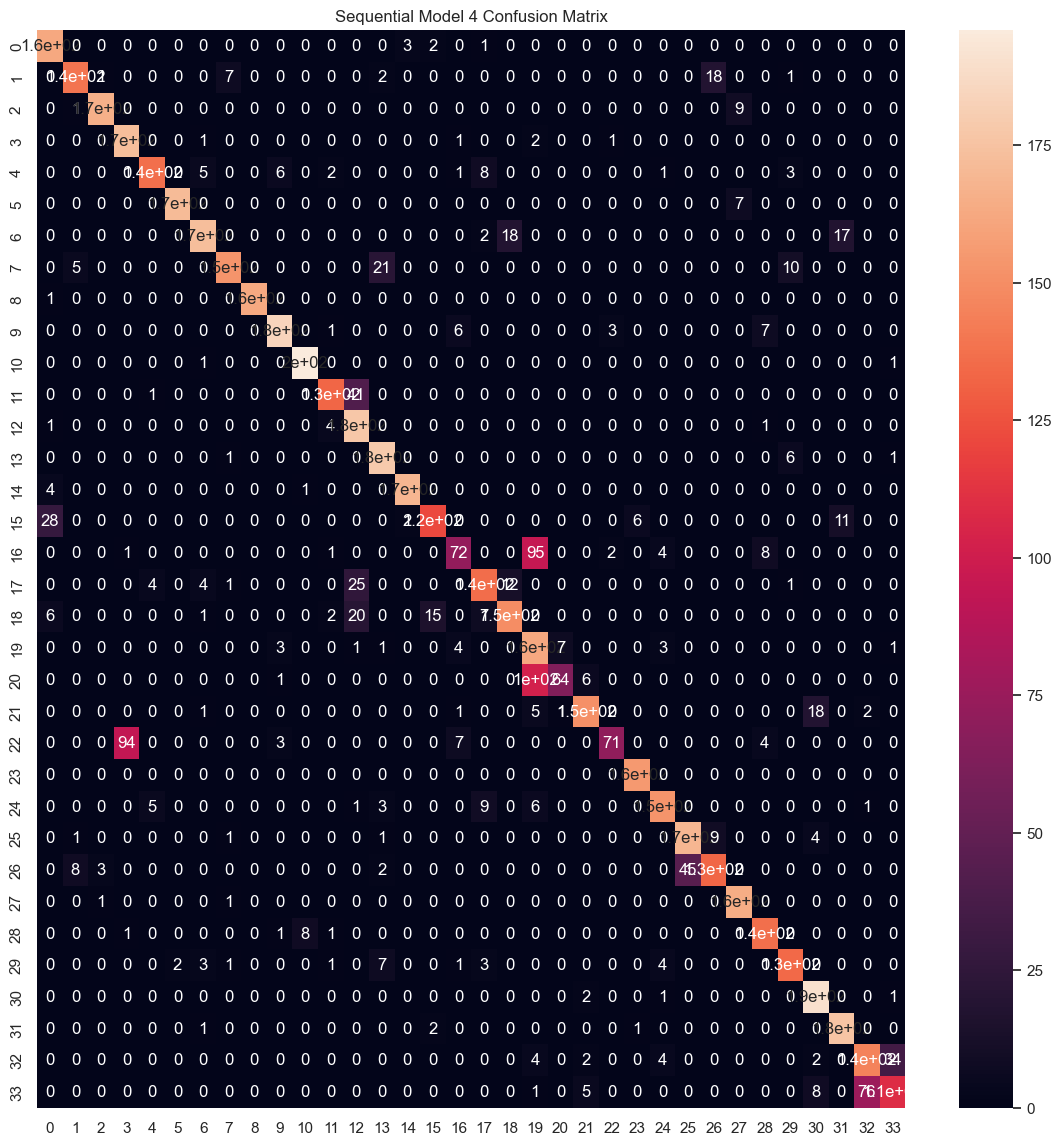

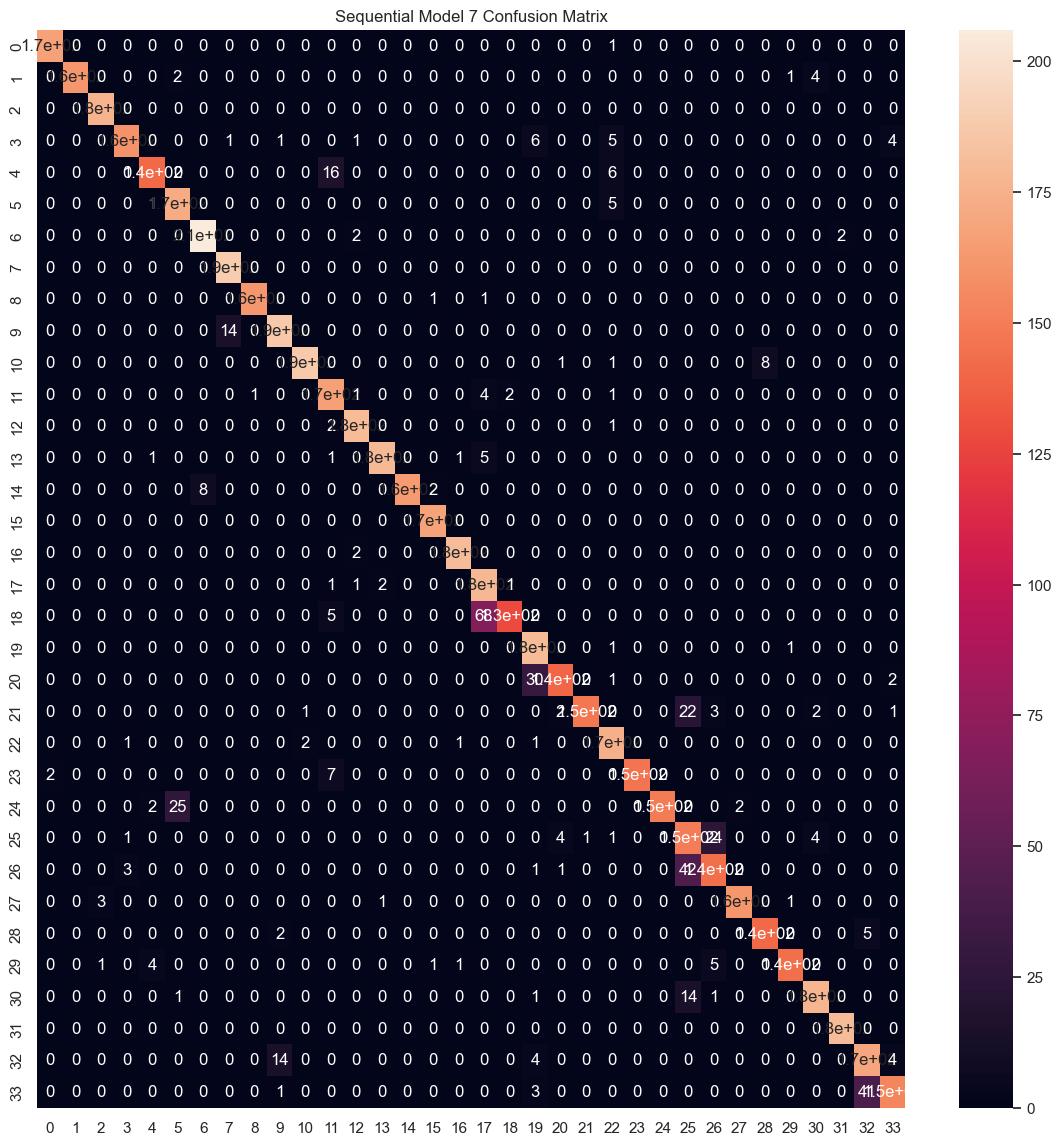

In [147]:
#Creating a confusion matrix for our response variables [57] [58] [17] [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True)
plt.title('Sequential Model 4 Confusion Matrix')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred7), annot=True)
plt.title('Sequential Model 7 Confusion Matrix')
plt.show()

# Random Forest

In [101]:
%%time
#creating a random forest classifier with the default parameters [59]
rf_clf = RandomForestClassifier(random_state=42)
rf_fitted = rf_clf.fit(X_train, y_train)
rf_preds = rf_fitted.predict(X_test)

CPU times: total: 9.58 s
Wall time: 21.1 s


In [115]:
from sklearn.metrics import accuracy_score
#getting the precision, recall, and accuracy score for the model [54] [55] [60]
rf_rec = recall_score(rf_preds, y_test, average='weighted')
rf_prec = precision_score(rf_preds, y_test, average='weighted')
rf_acc = accuracy_score(rf_preds, y_test)
#printing the scores [4]
print( 'Accuracy: ', rf_acc, 'Precision: ', rf_prec, 'Recall: ', rf_rec)

Accuracy:  0.9945928232017041 Precision:  0.994646971191253 Recall:  0.9945928232017041


In [94]:
#printing our classification report [56] [4]
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       168
           1       1.00      0.99      1.00       168
           2       0.99      1.00      1.00       176
           3       0.97      0.99      0.98       178
           4       1.00      1.00      1.00       163
           5       0.98      1.00      0.99       178
           6       1.00      1.00      1.00       210
           7       1.00      1.00      1.00       189
           8       1.00      0.99      1.00       164
           9       1.00      1.00      1.00       201
          10       0.99      0.99      0.99       198
          11       0.99      0.99      0.99       175
          12       0.99      1.00      1.00       183
          13       0.99      0.99      0.99       187
          14       0.99      0.99      0.99       174
          15       0.99      1.00      0.99       168
          16       1.00      1.00      1.00       183
          17       0.99    

<function matplotlib.pyplot.show(close=None, block=None)>

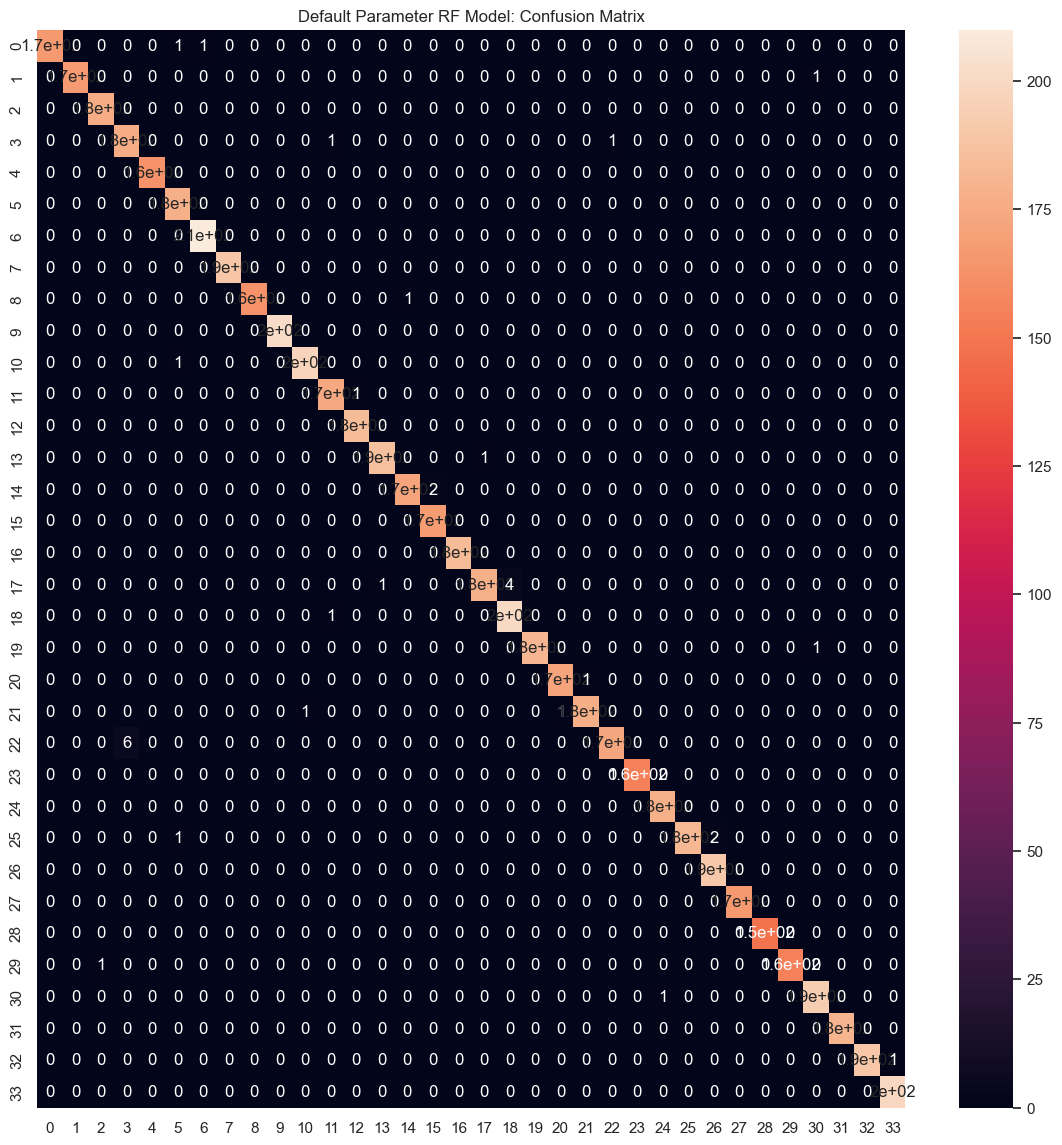

In [104]:
#creating the confusion matrix [57] [58] [17] [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True)
plt.title('Default Parameter RF Model: Confusion Matrix')
plt.show

In [97]:
%%time
# Using Grid Search CV to find the optimal hyper parameters for the dataset
#Setting the parameter grid for the random forest classifier using the default params as the [59]
param_grid = {'max_depth': [5,15,25,35], 'n_estimators': [50,75,100,125,150], 
              'min_samples_split': [1,2,3,4,5]}
# using grid search to identify our best parameters using the above param grid [59] [61]
rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
#fitting the data
rf_fitted = rf_gs.fit(X_train, y_train)
#getting the best params
rf_fitted.best_params_

CPU times: total: 31min 48s
Wall time: 1h 7min 22s


{'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 100}

In [103]:
%%time
#running the new random forest model with the best parameters from our gridsearch [59]
rf2 = RandomForestClassifier(max_depth= 25, n_estimators= 100, min_samples_split=3, random_state=42)
#fitting the data and getting our predicitons [59]
rf_fitted2 = rf2.fit(X_train, y_train)
rf_preds2 = rf_fitted2.predict(X_test)


CPU times: total: 9.17 s
Wall time: 21.2 s


In [114]:
#Getting the recall precision and accuracy score for our new model using sklearn metrics [54] [55] [60]
rf_rec2 = recall_score(rf_preds2, y_test, average='weighted')
rf_prec2 = precision_score(rf_preds2, y_test, average='weighted')
rf_acc2 = accuracy_score(rf_preds2, y_test)
#printing the scores [4]
print( 'Accuracy: ', rf_acc2, 'Precision: ', rf_prec2, 'Recall: ', rf_rec2)

Accuracy:  0.9949205308864493 Precision:  0.9949691769205709 Recall:  0.9949205308864493


In [100]:
#printing our classification report for the best random forest model [56] [4]
print(classification_report(y_test, rf_preds2))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       168
           1       1.00      1.00      1.00       168
           2       0.99      1.00      1.00       176
           3       0.97      0.99      0.98       178
           4       1.00      1.00      1.00       163
           5       0.99      1.00      0.99       178
           6       1.00      1.00      1.00       210
           7       1.00      1.00      1.00       189
           8       1.00      0.99      1.00       164
           9       1.00      1.00      1.00       201
          10       0.99      0.99      0.99       198
          11       0.99      0.99      0.99       175
          12       0.99      1.00      1.00       183
          13       0.99      0.99      0.99       187
          14       1.00      0.99      0.99       174
          15       0.98      1.00      0.99       168
          16       1.00      1.00      1.00       183
          17       0.99    

<function matplotlib.pyplot.show(close=None, block=None)>

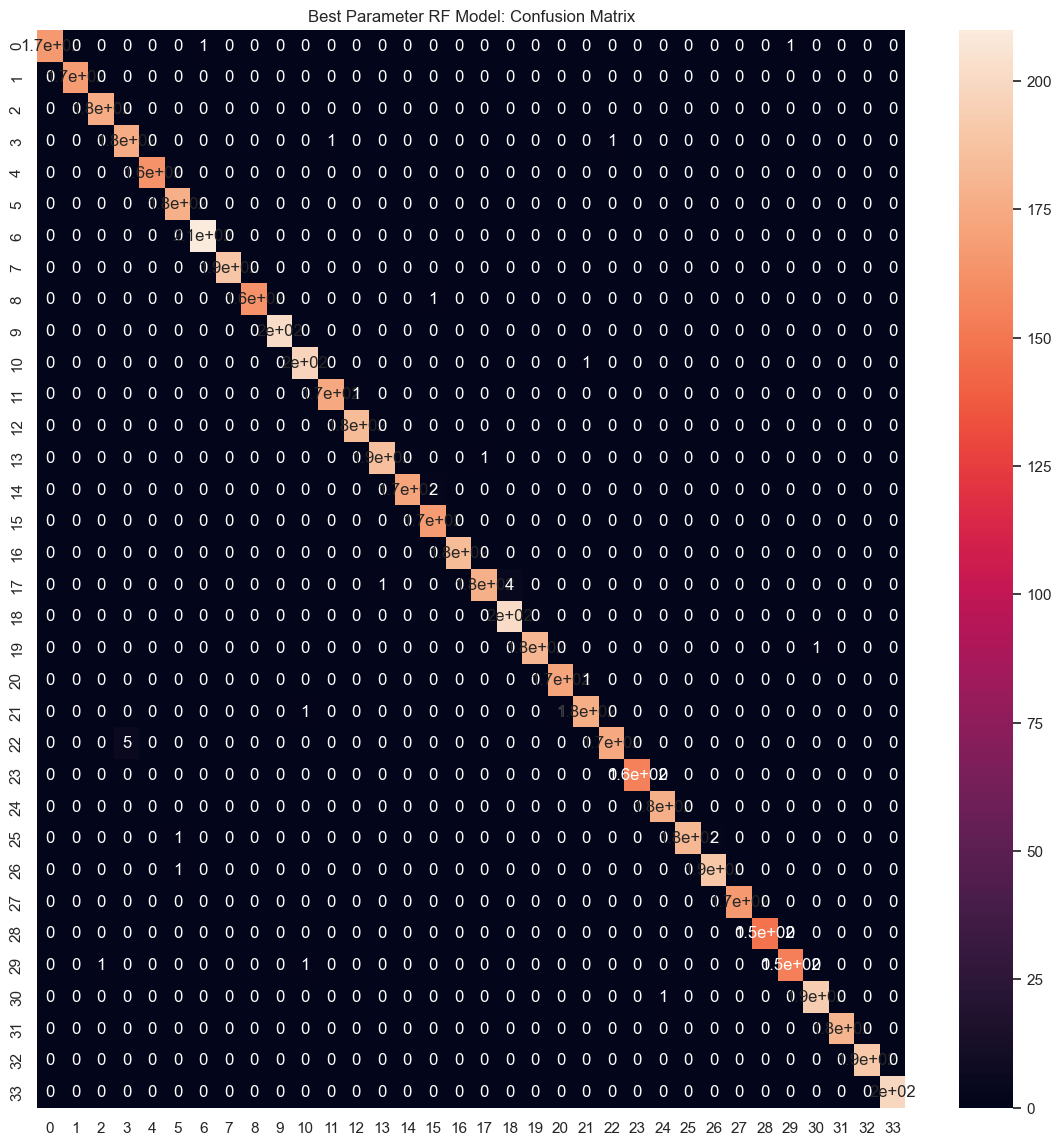

In [105]:
#creating the confusion matrix for the best param model [57] [58] [17] [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(confusion_matrix(y_test, rf_preds2), annot=True)
plt.title('Best Parameter RF Model: Confusion Matrix')
plt.show

# Support Vector Machine 

In [107]:
%%time
#running a support vector classifier on the data using the generic parameters [62]
svc = svm.SVC(random_state=42, decision_function_shape='ovo')
svc_fitted = svc.fit(X_train, y_train)
svc_preds = svc_fitted.predict(X_test)

CPU times: total: 5.69 s
Wall time: 10.5 s


In [112]:
#getting the precision, recall, and accuracy score for the model [54] [55] [60]
svc_rec = recall_score(svc_preds, y_test, average='weighted')
svc_prec = precision_score(svc_preds, y_test, average='weighted')
svc_acc = accuracy_score(svc_preds, y_test)
#printing the scores [4]
print( 'Accuracy: ', svc_acc, 'Precision: ', svc_prec, 'Recall: ', svc_rec)

Accuracy:  0.9877109618220548 Precision:  0.9880298339884759 Recall:  0.9877109618220548


In [108]:
#printing our classification report for the best support vector model [56] [4]
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       168
           1       1.00      0.98      0.99       168
           2       0.99      1.00      0.99       176
           3       0.99      0.92      0.96       178
           4       1.00      0.97      0.98       163
           5       0.99      1.00      0.99       178
           6       0.99      1.00      1.00       210
           7       0.99      1.00      1.00       189
           8       1.00      0.99      1.00       164
           9       1.00      1.00      1.00       201
          10       0.99      0.99      0.99       198
          11       0.98      0.99      0.99       175
          12       0.98      1.00      0.99       183
          13       0.98      0.99      0.99       187
          14       1.00      0.99      0.99       174
          15       0.98      1.00      0.99       168
          16       0.98      0.97      0.98       183
          17       0.99    

<function matplotlib.pyplot.show(close=None, block=None)>

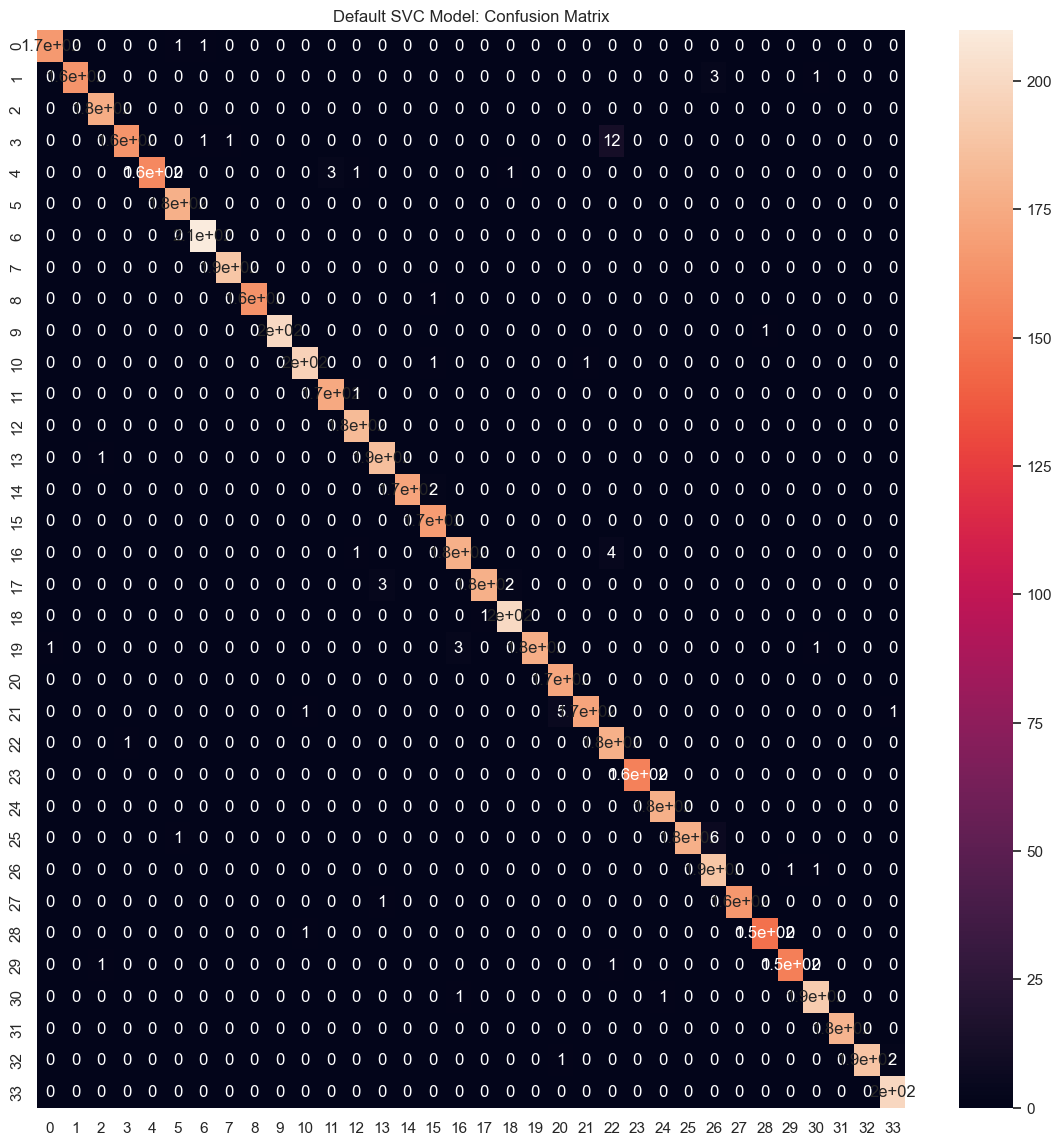

In [109]:
#creating the confusion matrix for the default svc model [57] [58] [17] [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(confusion_matrix(y_test, svc_preds), annot=True)
plt.title('Default SVC Model: Confusion Matrix')
plt.show

In [110]:
%%time
#creating our parameter grid using the different kernels and gammas [62]
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'gamma': ['scale', 'auto']}
# using grid search to identify our best parameters using the above param grid [61] [62]
svc_gs =  GridSearchCV(svm.SVC(random_state=42, decision_function_shape='ovo'), param_grid, cv=3)
svc_fitted = svc_gs.fit(X_train, y_train)
svc_fitted.best_params_

CPU times: total: 3min 49s
Wall time: 7min 24s


{'gamma': 'auto', 'kernel': 'poly'}

In [111]:
%%time
#after finding the best parameters from the previous gridsearch i decided to use that kernel and explore around the default degrees and gamma [62]
param_grid = {'degree': [1,2,3,4,5], 
              'gamma': ['scale', 'auto']}
#running another grid search [61] [62]
svc_gs =  GridSearchCV(svm.SVC(kernel='poly', random_state=42, decision_function_shape='ovo'), param_grid, cv=3)
svc_fitted = svc_gs.fit(X_train, y_train)
svc_fitted.best_params_

CPU times: total: 33 s
Wall time: 1min 9s


{'degree': 5, 'gamma': 'scale'}

In [113]:
%%time
#The degree returned the maximum input it was given so I made that the median to search around [62]
param_grid = {'degree': [3,4,5,6,7], 
              'gamma': ['scale', 'auto']}
#running another gridsearch [61] [62]
svc_gs =  GridSearchCV(svm.SVC(kernel='poly', random_state=42, decision_function_shape='ovo'), param_grid, cv=3)
svc_fitted = svc_gs.fit(X_train, y_train)
svc_fitted.best_params_

CPU times: total: 20.2 s
Wall time: 40.7 s


{'degree': 5, 'gamma': 'scale'}

In [110]:
%%time
#returned the same results so I took those as our best parameters and trained a model [62]
svc2 = svm.SVC(kernel='poly', degree=5, gamma='scale', random_state=42, decision_function_shape='ovo')
svc_fitted2 = svc2.fit(X_train, y_train)
svc_pred2 = svc_fitted2.predict(X_test)

CPU times: total: 797 ms
Wall time: 1.74 s


In [111]:
#getting the precision, recall, and accuracy score for the model [54] [55] [60]
svc_rec2 = recall_score(svc_pred2, y_test, average='weighted')
svc_prec2 = precision_score(svc_pred2, y_test, average='weighted')
svc_acc2 = accuracy_score(svc_pred2, y_test)
#printing the scores [4]
print( 'Accuracy: ', svc_acc2, 'Precision: ', svc_prec2, 'Recall: ', svc_rec2)

Accuracy:  0.9952482385711945 Precision:  0.9952761193187679 Recall:  0.9952482385711945


In [116]:
#printing our classification report for the best support vector machine model [56] [4]
print(classification_report(y_test, svc_pred2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       168
           1       1.00      1.00      1.00       168
           2       0.99      1.00      1.00       176
           3       0.98      0.98      0.98       178
           4       1.00      0.99      1.00       163
           5       0.98      1.00      0.99       178
           6       1.00      1.00      1.00       210
           7       0.99      1.00      1.00       189
           8       1.00      0.99      1.00       164
           9       1.00      1.00      1.00       201
          10       0.99      0.99      0.99       198
          11       1.00      0.99      1.00       175
          12       0.99      1.00      1.00       183
          13       0.99      1.00      1.00       187
          14       1.00      0.99      1.00       174
          15       0.99      1.00      0.99       168
          16       1.00      1.00      1.00       183
          17       1.00    

<function matplotlib.pyplot.show(close=None, block=None)>

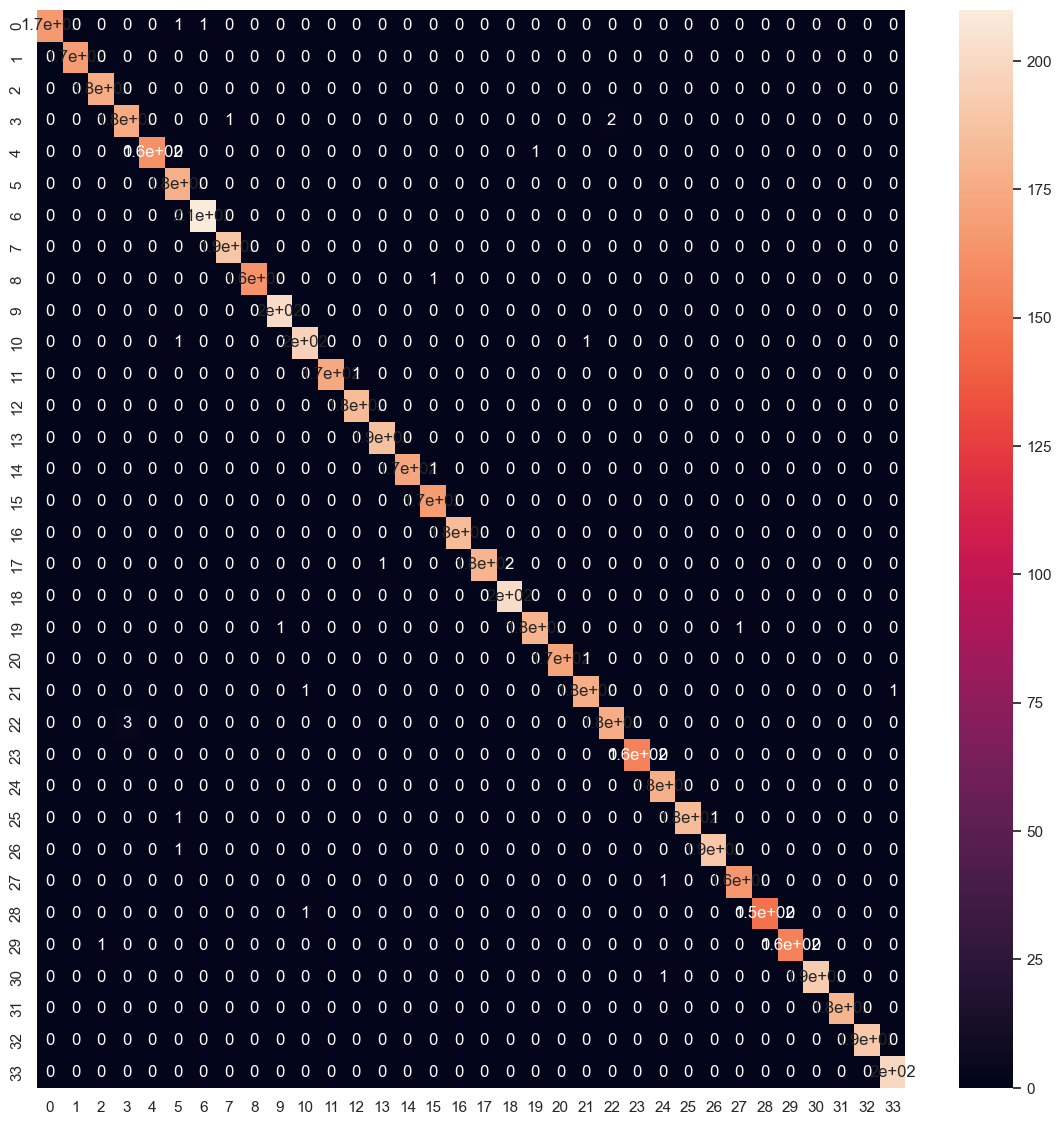

In [117]:
#creating the confusion matrix for the best param model [57] [58] [17] [22] [23] 24] [25] [26]
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(confusion_matrix(y_test, svc_pred2), annot=True)
plt.show

# Comparative Analysis

In [120]:
#creating the tabular data for the full and reduced datasets for the final analysis
#making the list that we will use for the index [66]
item = ['Accuracy', 'Precision', 'Recall']
#Creating our Sequential dataframe [1]
seq_df = pd.DataFrame(
    [[acc4, acc7], [ prec4, prec7], 
     [rec4, rec7]],
     columns=["Default", "Best Params"], index=item)
#creating the random forest dataframe [1]
rf_df = pd.DataFrame(
    [[ rf_acc, rf_acc2], [ rf_prec, rf_prec2], 
     [ rf_rec, rf_rec2]],
     columns=["Default", "Best Params"], index=item
)
#creating the Support Vector dataframe[1]
svc_df = pd.DataFrame(
    [[ svc_acc , svc_acc2],[ svc_prec, svc_prec2],
     [ svc_rec, svc_rec2]], 
    columns=["Default", "Best Params"], index=item
)
#concatenating the dataframes so they look stacked like in the example [37]
tab_df = pd.concat([seq_df, rf_df, svc_df], names = ['Models', 'Metric'],keys=['Sequential Model','Random Forest', 'Support Vector Machine'])
tab_df

Default  Best Params
Models                 Metric                          
Sequential Model       Accuracy   0.830247     0.919220
                       Precision  0.851736     0.927742
                       Recall     0.830247     0.919220
Random Forest          Accuracy   0.994593     0.994921
                       Precision  0.994647     0.994969
                       Recall     0.994593     0.994921
Support Vector Machine Accuracy   0.987711     0.995248
                       Precision  0.988030     0.995276
                       Recall     0.987711     0.995248

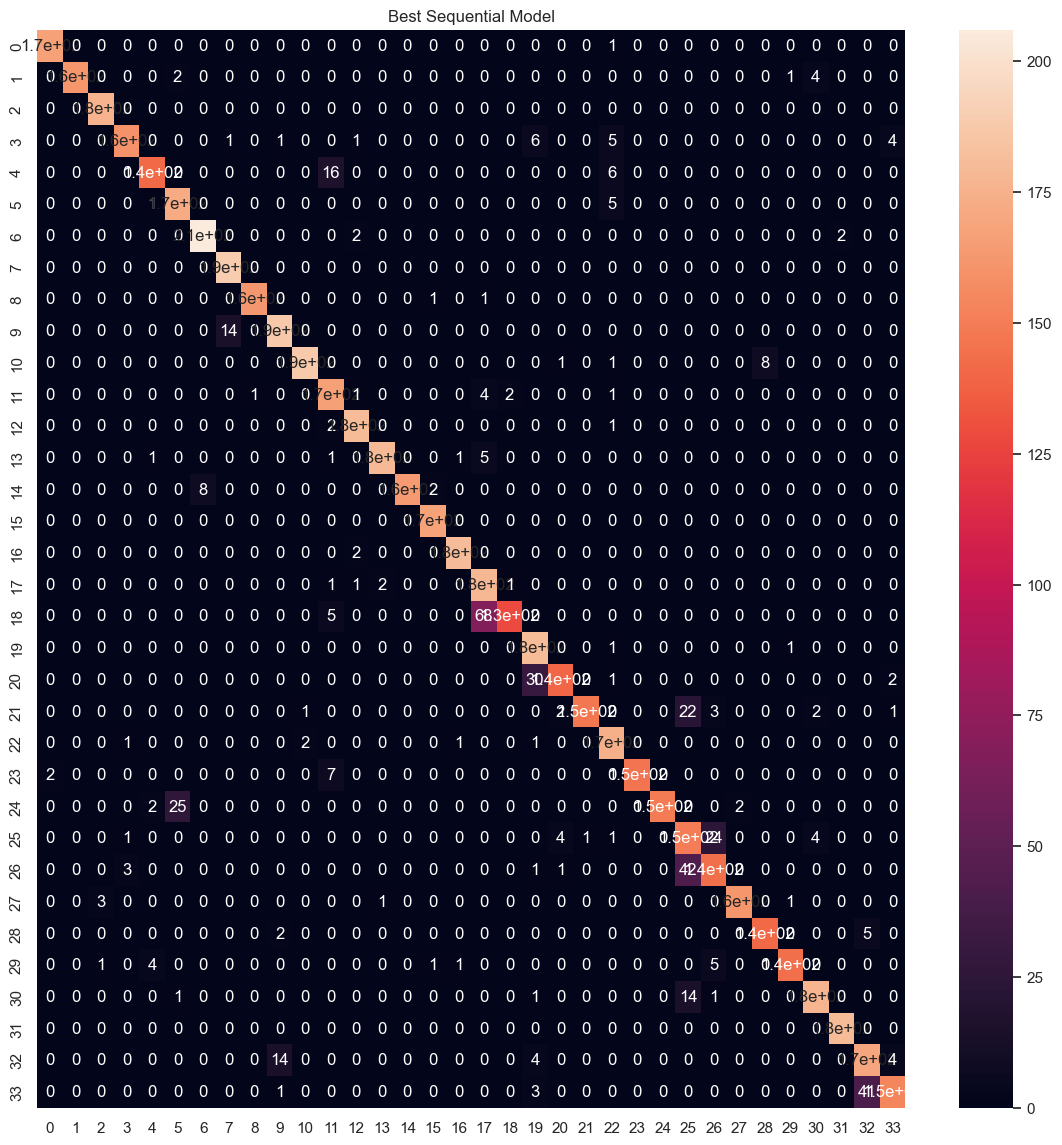

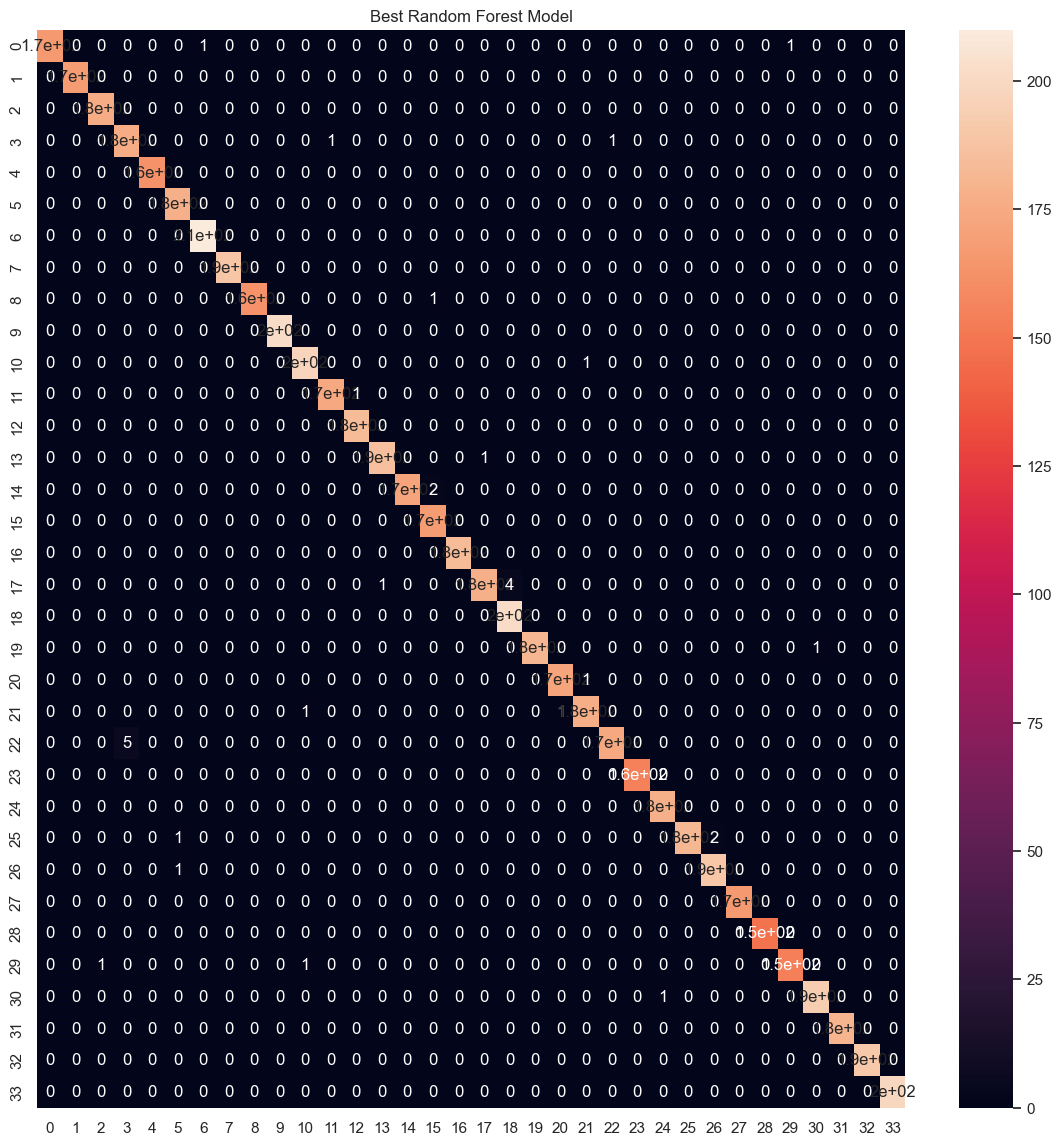

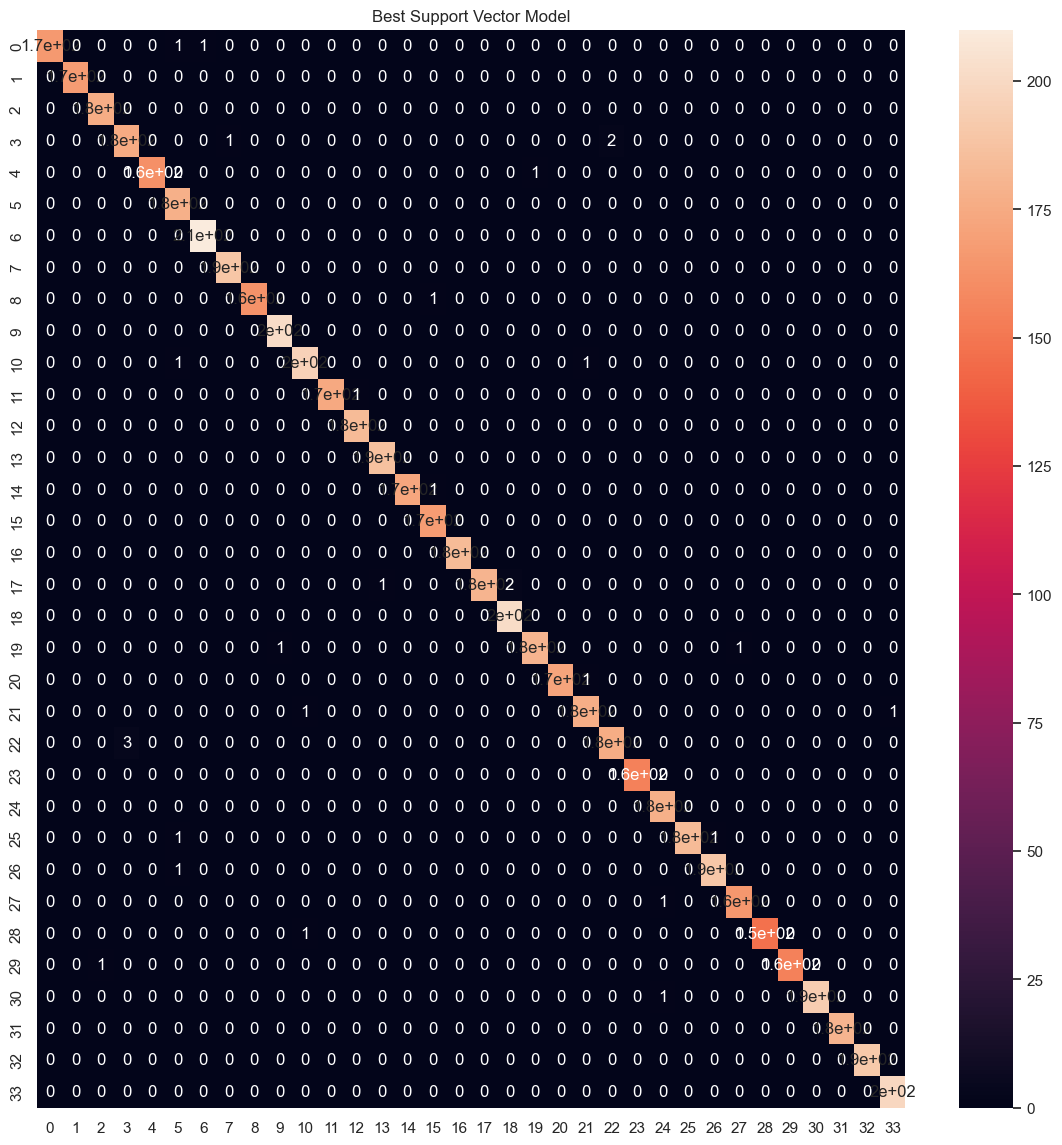

In [148]:
fig = plt.figure()

 #Creating a confusion matrix for our response variables [57] [58] [17] [22] [23] 24] [25] [26]
sns.heatmap(confusion_matrix(y_test, y_pred7), annot=True)
plt.title("Best Sequential Model")
plt.show()
sns.heatmap(confusion_matrix(y_test, rf_preds2), annot=True)
plt.title("Best Random Forest Model")
plt.show()
sns.heatmap(confusion_matrix(y_test, svc_pred2), annot=True)
plt.title("Best Support Vector Model")
plt.show()

# Conclusion
- Based on the overall metrics the support vector machine classifier slightly outperforms the random forest classifier and does significantly better than the Sequential model.
- When looking over the heatmap to indicate where the model is performing better the models are misclassifing similar gestures but the SVC misclassfies the gestures less.
Overall, the SVC model is the best model that was trained and will be implemented into the final application.

In [118]:
# using picke to create a file called 'svc_model' of our best model to use in our final application [63]
f = open('svc_model.pkl', 'wb')
#using the dump function to create a dictionary housing the model and dumping it into our file and closing the file [63]
pickle.dump({'model': svc2}, f)
f.close()

In [126]:
#Using the inverse transform function on the label encoded response variables to get the actual class names [4] [38] [39]
ytest_uni = np.unique(y_test)
inv_y = label_encoded.inverse_transform(ytest_uni)
print(ytest_uni)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [127]:
#printing the labels [4]
print(inv_y)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'eight' 'five' 'four' 'nine' 'one' 'seven' 'six'
 'ten' 'three' 'two']


## References:
    [1] “pandas.DataFrame — pandas 1.2.4 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
    [2] “pandas.read_csv — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv (accessed Sep. 20, 2023).
    [3] “pandas.DataFrame.copy — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html#pandas.DataFrame.copy (accessed Sep. 20, 2023).
    [4] “Built-in Functions — Python 3.8.3 documentation,” docs.python.org. https://docs.python.org/3/library/functions.html
    [5] “pandas.DataFrame.shape — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html#pandas.DataFrame.shape (accessed Sep. 20, 2023).
    [6] “pandas.DataFrame.isnull — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull (accessed Sep. 20, 2023).
    [7] “pandas.DataFrame.isna — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html#pandas.DataFrame.isna (accessed Sep. 20, 2023).
    [8] “pandas.DataFrame.values — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html#pandas.DataFrame.values (accessed Sep. 20, 2023).
    [9] “pandas.DataFrame.any — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.any.html#pandas.DataFrame.any (accessed Sep. 20, 2023).
    [10] “matplotlib.figure — Matplotlib 3.5.1 documentation,” matplotlib.org. https://matplotlib.org/stable/api/figure_api.html
    [11] “Indexing and selecting data — pandas 1.5.1 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/user_guide/indexing.html
    [12] “pandas.DataFrame.value_counts — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html#pandas.DataFrame.value_counts (accessed Sep. 20, 2023).
    [13] “pandas.DataFrame.plot — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html#pandas.DataFrame.plot (accessed Sep. 20, 2023).
    [14] “matplotlib.axes.Axes.set_xticks — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html (accessed Sep. 20, 2023).
    [15] “matplotlib.axes.Axes.get_xticks — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_xticks.html#matplotlib.axes.Axes.get_xticks (accessed Sep. 20, 2023).
    [16] “matplotlib.axes.Axes.set_xlabel — Matplotlib 3.7.1 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlabel.html
    [17] “matplotlib.pyplot.show — Matplotlib 3.5.1 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
    [18] “matplotlib.pyplot.title — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html#matplotlib.pyplot.title (accessed Sep. 20, 2023).
    [19] “3.2 - Identifying Outliers: IQR Method | STAT 200,” PennState: Statistics Online Courses. https://online.stat.psu.edu/stat200/lesson/3/3.2
    [20] “4. More Control Flow Tools,” Python documentation. https://docs.python.org/3/tutorial/controlflow.html?highlight=control%20flow (accessed Sep. 20, 2023)
    [21] “pandas.DataFrame.quantile — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html#pandas.DataFrame.quantile (accessed Sep. 20, 2023).
    [22] “Customizing Matplotlib with style sheets and rcParams — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/users/explain/customizing.html (accessed Sep. 20, 2023).
    [23] “seaborn.set — seaborn 0.12.2 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/generated/seaborn.set.html?highlight=sns+set (accessed Sep. 20, 2023).
    [24] “seaborn.set_theme — seaborn 0.12.2 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme (accessed Sep. 20, 2023).
    [25] “python - How to change the figure size of a seaborn axes or figure level plot,” Stack Overflow. https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
    [26] “Controlling figure aesthetics — seaborn 0.12.2 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/tutorial/aesthetics.html?highlight=sns+set+rc (accessed Sep. 20, 2023).
    [27] “seaborn.histplot — seaborn 0.12.2 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/generated/seaborn.histplot.html?highlight=sns+histplot (accessed Sep. 20, 2023).
    [28] “matplotlib.axes.Axes.axhline — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axhline.html#matplotlib.axes.Axes.axhline (accessed Sep. 20, 2023).
    [29] “pandas.DataFrame.mean — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html#pandas.DataFrame.mean (accessed Sep. 20, 2023).
    [30] “matplotlib.axes.Axes.axhspan — Matplotlib 3.8.0 documentation,” matplotlib.org. https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axhspan.html#matplotlib.axes.Axes.axhspan (accessed Sep. 20, 2023).
    [31] “seaborn.boxplot — seaborn 0.12.2 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=seaborn+boxplot#seaborn.boxplot (accessed Sep. 20, 2023).
    [32] D. N. (bookdown translation: E. Kothe), Chapter 5 Descriptive statistics | Learning statistics with R: A tutorial for psychology students and other beginners. (Version 0.6.1). Available: https://learningstatisticswithr.com/book/descriptives.html
    [33] “matplotlib.legend — Matplotlib 3.5.1 documentation,” matplotlib.org. https://matplotlib.org/stable/api/legend_api.html
    [34] “pandas.DataFrame.index — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.index.html#pandas.DataFrame.index (accessed Sep. 20, 2023).
    [35] “pandas.DataFrame.drop — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html#pandas.DataFrame.drop (accessed Sep. 20, 2023).
    [36] “pandas.DataFrame.replace — pandas 2.1.0 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html#pandas.DataFrame.replace (accessed Sep. 20, 2023).
    [37] “pandas.concat — pandas 2.1.1 documentation,” pandas.pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat (accessed Sep. 20, 2023).
    [38] “numpy.unique — NumPy v1.26 Manual,” numpy.org. https://numpy.org/doc/stable/reference/generated/numpy.unique.html#numpy-unique (accessed Sep. 20, 2023).
    [39] “sklearn.preprocessing.LabelEncoder — scikit-learn 0.22.1 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    [40] scikit-learn, “sklearn.model_selection.train_test_split — scikit-learn 0.20.3 documentation,” Scikit-learn.org, 2018. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    [41] K. Team, “Keras documentation: The Sequential class,” keras.io. https://keras.io/api/models/sequential/
    [42] K. Team, “Keras documentation: Dense layer,” keras.io. https://keras.io/api/layers/core_layers/dense/
    [43] K. Team, “Keras documentation: ReLU layer,” keras.io. https://keras.io/api/layers/activation_layers/relu/
    [44] K. Team, “Keras documentation: Softmax layer,” keras.io. https://keras.io/api/layers/activation_layers/softmax/
    [45] Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. “O’Reilly Media, Inc.,” 2022.
    [46] K. Team, “Keras documentation: Optimizers,” keras.io. https://keras.io/api/optimizers/
    [47] K. Team, “Keras documentation: Adam,” keras.io. https://keras.io/api/optimizers/adam/
    [48] K. Team, “Keras documentation: Probabilistic losses,” keras.io. https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class
    [49] K. Team, “Keras documentation: Accuracy metrics,” Keras.io, 2023. https://keras.io/api/metrics/accuracy_metrics/#accuracy-class (accessed Sep. 21, 2023).
    [50] K. Team, “Keras documentation: Model training APIs,” keras.io. https://keras.io/api/models/model_training_apis/
    [51] K. Team, “Keras documentation: Reproducibility in Keras Models,” Keras.io, 2023. https://keras.io/examples/keras_recipes/reproducibility_recipes/ (accessed Sep. 21, 2023).
    [52] K. Team, “Keras documentation: Training & evaluation with the built-in methods,” keras.io. https://keras.io/guides/training_with_built_in_methods/
    [53] “numpy.argmax — NumPy v1.26 Manual,” numpy.org. https://numpy.org/doc/stable/reference/generated/numpy.argmax.html#numpy.argmax (accessed Sep. 21, 2023).
    [54] “sklearn.metrics.precision_score — scikit-learn 0.24.1 documentation,” scikit-learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
    [55] “sklearn.metrics.recall_score,” scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    [56] “sklearn.metrics.classification_report — scikit-learn 0.20.3 documentation,” Scikit-learn.org, 2018. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    [57] scikit-learn, “sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    [58] “seaborn.heatmap — seaborn 0.10.1 documentation,” seaborn.pydata.org. https://seaborn.pydata.org/generated/seaborn.heatmap.html
    [59] “3.2.4.3.1. sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
    [60] “sklearn.metrics.accuracy_score — scikit-learn 0.24.1 documentation,” scikit-learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    [61] “sklearn.model_selection.GridSearchCV — scikit-learn 0.22 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
    [62] “sklearn.svm.SVC — scikit-learn 0.22 documentation,” Scikit-learn.org, 2019. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    [63] Python Software Foundation, “pickle — Python object serialization — Python 3.7.3 documentation,” Python.org, 2019. https://docs.python.org/3/library/pickle.html
    [64] Sandhyakrishnan, “How to determine the number of layers and neurons in the hidden layer?,” Medium, Sep. 10, 2021. https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
    [65] “Print Newline in Python – Printing a New Line,” freeCodeCamp.org, Mar. 22, 2023. https://www.freecodecamp.org/news/print-newline-in-python/#:~:text=Using%20the%20escape%20character%20%5Cn
    [66] “5. Data Structures — Python 3.8.3 documentation,” docs.python.org. https://docs.python.org/3/tutorial/datastructures.html